## Function

In [1]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
#     plt.figure()
#     generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
#     plt.show()

In [2]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

In [3]:
def show_values(axs, orient="v", space=.01, fmt='{:.4f}', fsize=18):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = fmt.format(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize=fsize) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = fmt.format(p.get_width())
                ax.text(_x, _y, value, ha="left", fontsize=fsize)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

## Library

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import pyswarms as ps
import matplotlib.pyplot as plt
import xlsxwriter

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from collections import Counter

from sklearn.metrics import confusion_matrix
import itertools

from ipynb.fs.full.DistanceWeightedKNN import DistanceWeightedKNN

In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

In [5]:
df= pd.read_csv("DATASET/Prostate.csv")
df.head(10)

Class  AFFX-MurIL2_at  AFFX-MurIL10_at  AFFX-MurIL4_at  AFFX-MurFAS_at  \
0  Tumor            -9.0              1.0             1.0            15.0   
1  Tumor            -2.0              1.0             1.0             4.0   
2  Tumor            -6.0             17.0             6.0            29.0   
3  Tumor             0.0              9.0             4.0            19.0   
4  Tumor            -1.0              0.0             1.0             5.0   
5  Tumor             0.0             17.0             1.0            20.0   
6  Tumor            -5.0              5.0            -1.0             9.0   
7  Tumor            -3.0              1.0             1.0             5.0   
8  Tumor            -8.0             -2.0            -1.0           -32.0   
9  Tumor           -12.0             11.0            -3.0            21.0   

   AFFX-BioB-5_at  AFFX-BioB-M_at  AFFX-BioB-3_at  AFFX-BioC-5_at  \
0            -2.0            -3.0             4.0             8.0   
1            -2.0            -5.0             0.0             8.0   
2             4.0           -11.0            -8.0            10.0   
3           -10.0           -18.0           -18.0             5.0   
4             0.0            -4.0             1.0             6.0   
5           -20.0           -18.0            -2.0            15.0   
6           -10.0           -17.0            -8.0            13.0   
7            -2.0            -6.0             0.0             0.0   
8           -20.0           -41.0             1.0            30.0   
9           -10.0            -9.0            -9.0            12.0   

   AFFX-BioC-3_at  ...  100_g_at  101_at  102_at  103_at  104_at  105_at  \
0           -12.0  ...      39.0     5.0     3.0      21    15.0     1.0   
1            -5.0  ...      34.0     3.0     2.0      12     7.0     4.0   
2           -24.0  ...      86.0    -5.0    11.0      11    36.0     8.0   
3           -33.0  ...      98.0    -7.0     6.0       9    22.0     3.0   
4            -4.0  ...      33.0     6.0     1.0     140    10.0     3.0   
5            -9.0  ...      60.0    -3.0     3.0      10    14.0     7.0   
6           -15.0  ...      93.0    -9.0     6.0      19    27.0    13.0   
7            -4.0  ...      21.0    18.0     1.0       9     5.0     0.0   
8           -23.0  ...      64.0    -5.0    -2.0       5    27.0     2.0   
9           -29.0  ...      63.0   -27.0    27.0      17    17.0    16.0   

   106_at  107_at  108_g_at  109_at  
0       0    14.0     -23.0    14.0  
1       5     4.0     -10.0    25.0  
2       7    21.0     -82.0    10.0  
3      20    -7.0     -62.0    24.0  
4       8     8.0     -27.0    20.0  
5       4    18.0     -74.0    30.0  
6      13    21.0     -60.0    17.0  
7       0     6.0      -2.0    23.0  
8      31    60.0    -114.0    -2.0  
9       3   -16.0     -57.0     2.0  

[10 rows x 12601 columns]

In [6]:
#jumlah class
df.Class.value_counts()

Tumor     77
Normal    59
Name: Class, dtype: int64

2022-07-18 15:43:39,590 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 15:43:39,592 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 15:43:39,630 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 15:43:39,632 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 15:43:39,707 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-18 15:43:39,709 - matplotlib.text - WARNING - posx and posy should be finite values


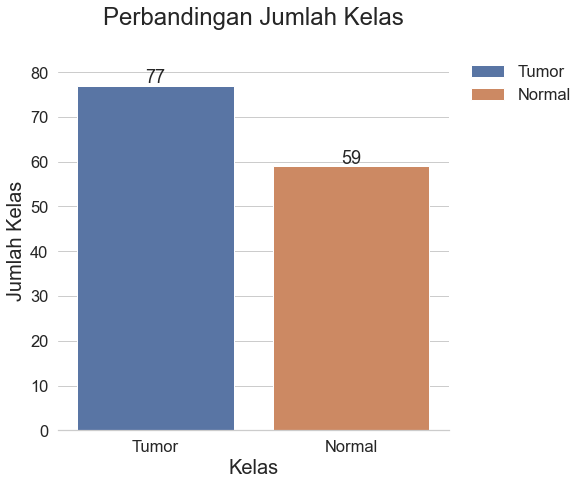

In [7]:
plt.figure(figsize=(7,7))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
p = sns.countplot(x=df.Class, hue=df.Class, dodge=False, data=df)
sns.despine(left=True)
p.set_title('Perbandingan Jumlah Kelas', fontsize=24, y=1.05)
p.set_ylabel('Jumlah Kelas', fontsize=20)
p.set_xlabel('Kelas', fontsize=20)
p.set_ylim(0, 85)
# plt.legend(labels=['Tumor', 'Normal'], frameon=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', labels=['Tumor', 'Normal'], frameon=False)
show_values(p, fmt='{:.0f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/JumlahClass.png', legend=p.get_legend)

In [8]:
encode = LabelEncoder()
df['Class'] = encode.fit_transform(df['Class'])
df.Class.value_counts()

1    77
0    59
Name: Class, dtype: int64

In [9]:
class_names = np.unique(df.Class)
class_names

array([0, 1])

In [10]:
X = df.drop(columns='Class').values
y = df.Class.values
print(Counter(y))

Counter({1: 77, 0: 59})


In [11]:
#normalisasi
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X)

0         1         2         3         4         5         6      \
0    0.849206  0.259259  0.089041  0.326389  0.058473  0.110619  0.068670   
1    0.904762  0.259259  0.089041  0.250000  0.058473  0.108407  0.062947   
2    0.873016  0.456790  0.123288  0.423611  0.065632  0.101770  0.051502   
3    0.920635  0.358025  0.109589  0.354167  0.048926  0.094027  0.037196   
4    0.912698  0.246914  0.089041  0.256944  0.060859  0.109513  0.064378   
..        ...       ...       ...       ...       ...       ...       ...   
131  0.444444  0.876543  0.465753  0.680556  0.377088  0.366150  0.248927   
132  0.746032  0.061728  0.479452  0.701389  0.513126  0.600664  0.384835   
133  0.547619  0.456790  0.232877  0.513889  0.340095  0.311947  0.340486   
134  0.000000  0.148148  0.438356  1.000000  0.478520  0.488938  0.326180   
135  0.539683  0.469136  0.328767  0.548611  0.344869  0.306416  0.238913   

        7         8         9      ...     12590     12591     12592  \
0    0.009369  0.046492  0.026424  ...  0.095890  0.477178  0.180723   
1    0.009369  0.049398  0.027540  ...  0.078767  0.468880  0.168675   
2    0.010355  0.041511  0.018980  ...  0.256849  0.435685  0.277108   
3    0.007890  0.037775  0.019352  ...  0.297945  0.427386  0.216867   
4    0.008383  0.049813  0.027540  ...  0.075342  0.481328  0.156627   
..        ...       ...       ...  ...       ...       ...       ...   
131  0.450197  0.469489  0.388537  ...  0.304795  0.672199  0.638554   
132  0.577416  0.602740  0.529587  ...  0.174658  0.697095  0.903614   
133  0.325444  0.346617  0.310011  ...  0.592466  0.813278  1.000000   
134  0.643491  0.633458  0.526237  ...  0.582192  0.755187  0.843373   
135  0.295858  0.283105  0.261630  ...  0.592466  0.605809  0.493976   

        12593     12594     12595     12596     12597     12598     12599  
0    0.139706  0.124183  0.053030  0.672297  0.569355  0.714789  0.196517  
1    0.123162  0.071895  0.075758  0.689189  0.553226  0.760563  0.223881  
2    0.121324  0.261438  0.106061  0.695946  0.580645  0.507042  0.186567  
3    0.117647  0.169935  0.068182  0.739865  0.535484  0.577465  0.221393  
4    0.358456  0.091503  0.068182  0.699324  0.559677  0.700704  0.211443  
..        ...       ...       ...       ...       ...       ...       ...  
131  0.174632  0.490196  0.401515  0.493243  0.500000  1.000000  0.753731  
132  0.101103  0.699346  0.575758  0.293919  0.417742  0.841549  0.699005  
133  0.115809  0.771242  0.583333  0.685811  0.656452  0.802817  0.679104  
134  0.047794  0.542484  0.704545  0.706081  0.437097  0.570423  0.733831  
135  0.005515  0.490196  0.242424  0.851351  0.450000  0.514085  0.582090  

[136 rows x 12600 columns]

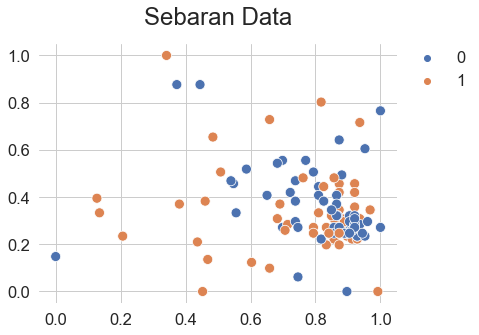

In [12]:
plt.figure(figsize=(7, 5))
plt.rcParams['figure.autolayout'] = True
sns.set_style('whitegrid')
p = sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, s=100)
p.set_title('Sebaran Data', fontsize=24, y=1.05)
sns.despine(left=True, bottom=True)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/ScatterPlot.png')

## Fold 2-10

In [71]:
fs_mdl = np.zeros(11)
fs_acc = np.zeros(11)
fs_prc = np.zeros(11)
fs_rcl = np.zeros(11)
fs_f1 = np.zeros(11)
ftr = np.zeros(11)
fs_pred = []
fs_act = []
fs_pos = []

X_train_fold = []
y_train_fold = []
X_test_fold = []
y_test_fold = []

for a in range(2, 11):
    print("FOLD :", a)

    #split menggunakan kfold
    folds = StratifiedKFold(n_splits=a, shuffle=True, random_state=42)

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for train_index, test_index in folds.split(X, y):
        X_train.append(X[train_index]), X_test.append(X[test_index]), y_train.append(y[train_index]), y_test.append(y[test_index])

    for i in range(folds.n_splits):
        print(Counter(y_train[i]))
        
    X_train_fold.append(X_train)
    y_train_fold.append(y_train)
    X_test_fold.append(X_test)
    y_test_fold.append(y_test)

    #modeling
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    #seleksi fitur BPSO
    def f_per_particle(m, alpha):
        total_features = X.shape[1]
        scores = np.zeros(folds.n_splits)

        for i in range(folds.n_splits):
            if np.count_nonzero(m) == 0:
                X_subset = X_train[i]
            else:
                X_subset = X_train[i][:,m==1]

            model.fit(X_subset, y_train[i])
            pred = model.predict(X_subset)
            scores[i] = accuracy_score(y_train[i], pred)

        P = np.mean(scores)

        j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
        return j

    def f(x, alpha=0.88):
        n_particles = x.shape[0]
        j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
        return np.array(j)

    #inisiasiBPSO
    ps.discrete.BinaryPSO

    #executeBPSO
    options = {'c1': 2, 'c2': 2, 'w':0.9, 'k': 30, 'p':2}
    dimensions = X.shape[1]
    optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
    cost, pos = optimizer.optimize(f, iters=10, verbose=3)

    fs_pos.append(pos)

    #model
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    mdl_scr = np.zeros(folds.n_splits)
    acc_scr = np.zeros(folds.n_splits)
    prc_scr = np.zeros(folds.n_splits)
    rcl_scr = np.zeros(folds.n_splits)
    f1_scr = np.zeros(folds.n_splits)
    pred_scr = []
    act_scr = []

    for i in range(folds.n_splits):
        X_train_selected = X_train[i][:,pos==1]
        X_test_selected = X_test[i][:,pos==1]

        #fit
        model.fit(X_train_selected, y_train[i])

        #predict
        pred = model.predict(X_test_selected)
        pred_scr.append(pred)
        act_scr.append(y_test[i])

        #accuracy
        mdl_scr[i] = model.score(X_train_selected, y_train[i])
        acc_scr[i] = accuracy_score(y_test[i], pred)
        prc_scr[i] = precision_score(y_test[i], pred, pos_label=1)
        rcl_scr[i] = recall_score(y_test[i], pred, pos_label=1)
        f1_scr[i] = f1_score(y_test[i], pred, pos_label=1)


    #collect acc, prc, rcl, f1 BPSO
    fs_mdl[a-1] = np.mean(mdl_scr)
    fs_acc[a-1] = np.mean(acc_scr)
    fs_prc[a-1] = np.mean(prc_scr)
    fs_rcl[a-1] = np.mean(rcl_scr)
    fs_f1[a-1] = np.mean(f1_scr)
    ftr[a-1] = np.count_nonzero(pos)
    fs_pred.append(pred_scr)
    fs_act.append(act_scr)    


ind_fs = np.argmax(fs_acc)
print('---------- BPSO ----------')
print('Fold : ', ind_fs+1)
print('Accuracy Model : %0.4f'%(fs_mdl[ind_fs]))
print('Mean Accuracy: %0.4f'%(np.max(fs_acc)))
print('Mean Precision: %0.4f'%(fs_prc[ind_fs]))
print('Mean Recall: %0.4f'%(fs_rcl[ind_fs]))
print('Mean F1: %0.4f'%(fs_f1[ind_fs]))

FOLD : 2
Counter({1: 38, 0: 30})
Counter({1: 39, 0: 29})


2022-07-18 18:09:56,802 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 18:10:06,397 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0576, best pos: [1 0 1 ... 1 0 0]
2022-07-18 18:10:06,566 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 3
Counter({1: 51, 0: 39})
Counter({1: 51, 0: 40})
Counter({1: 52, 0: 39})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-18 18:10:23,678 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057809523809523804, best pos: [0 1 1 ... 1 1 1]
2022-07-18 18:10:23,895 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 4
Counter({1: 57, 0: 45})
Counter({1: 58, 0: 44})
Counter({1: 58, 0: 44})
Counter({1: 58, 0: 44})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-18 18:10:49,297 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05808571428571428, best pos: [1 0 0 ... 1 0 0]
2022-07-18 18:10:49,564 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 5
Counter({1: 61, 0: 47})
Counter({1: 61, 0: 48})
Counter({1: 62, 0: 47})
Counter({1: 62, 0: 47})
Counter({1: 62, 0: 47})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-18 18:11:22,998 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057809523809523804, best pos: [0 0 0 ... 0 1 0]
2022-07-18 18:11:23,330 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 6
Counter({1: 64, 0: 49})
Counter({1: 64, 0: 49})
Counter({1: 64, 0: 49})
Counter({1: 64, 0: 49})
Counter({1: 64, 0: 50})
Counter({1: 65, 0: 49})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 18:12:04,826 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057628571428571425, best pos: [1 1 1 ... 0 1 1]
2022-07-18 18:12:05,204 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 7
Counter({1: 66, 0: 50})
Counter({1: 66, 0: 50})
Counter({1: 66, 0: 50})
Counter({1: 66, 0: 51})
Counter({1: 66, 0: 51})
Counter({1: 66, 0: 51})
Counter({1: 66, 0: 51})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 18:12:54,332 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0576, best pos: [0 1 1 ... 1 0 1]


FOLD : 8
Counter({1: 67, 0: 52})
Counter({1: 67, 0: 52})
Counter({1: 67, 0: 52})
Counter({1: 67, 0: 52})
Counter({1: 67, 0: 52})
Counter({1: 68, 0: 51})
Counter({1: 68, 0: 51})
Counter({1: 68, 0: 51})


2022-07-18 18:12:54,786 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 18:13:53,187 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05800952380952381, best pos: [1 0 1 ... 0 1 1]


FOLD : 9
Counter({1: 68, 0: 52})
Counter({1: 68, 0: 53})
Counter({1: 68, 0: 53})
Counter({1: 68, 0: 53})
Counter({1: 68, 0: 53})
Counter({1: 69, 0: 52})
Counter({1: 69, 0: 52})
Counter({1: 69, 0: 52})
Counter({1: 69, 0: 52})


2022-07-18 18:13:53,752 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 18:15:00,415 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057647619047619045, best pos: [0 0 0 ... 0 1 0]


FOLD : 10
Counter({1: 69, 0: 53})
Counter({1: 69, 0: 53})
Counter({1: 69, 0: 53})
Counter({1: 69, 0: 53})
Counter({1: 69, 0: 53})
Counter({1: 69, 0: 53})
Counter({1: 69, 0: 54})
Counter({1: 70, 0: 53})
Counter({1: 70, 0: 53})
Counter({1: 70, 0: 53})


2022-07-18 18:15:00,961 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.057
2022-07-18 18:16:16,190 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05701904761904761, best pos: [0 1 0 ... 1 1 1]


---------- BPSO ----------
Fold :  10
Accuracy Model : 1.0000
Mean Accuracy: 0.8533
Mean Precision: 0.8685
Mean Recall: 0.8804
Mean F1: 0.8680


Confusion matrix, without normalization


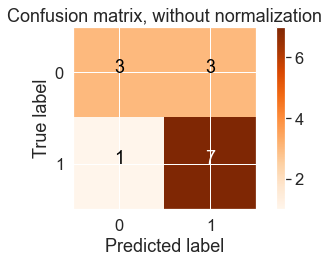

Confusion matrix, without normalization


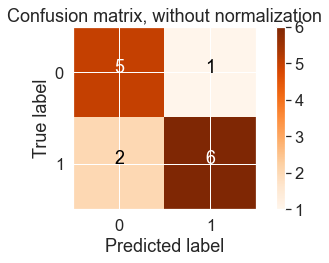

Confusion matrix, without normalization


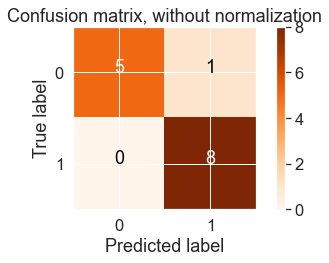

Confusion matrix, without normalization


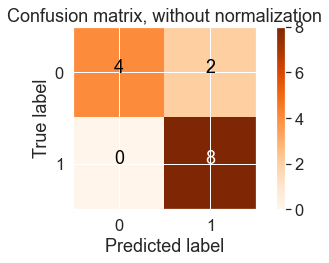

Confusion matrix, without normalization


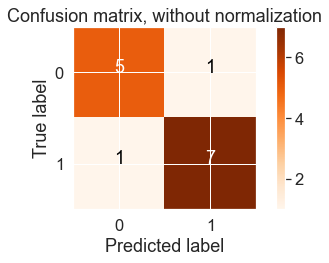

Confusion matrix, without normalization


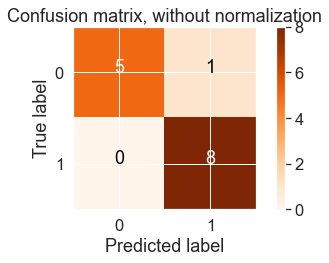

Confusion matrix, without normalization


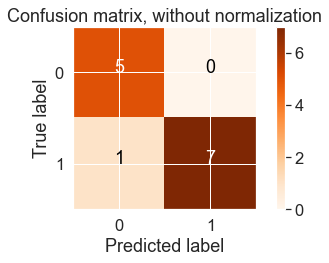

Confusion matrix, without normalization


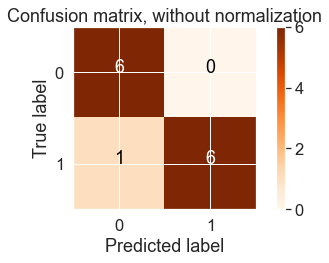

Confusion matrix, without normalization


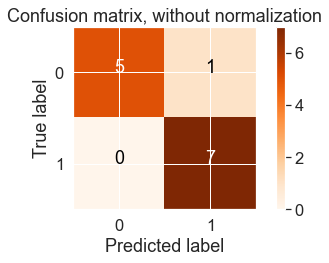

Confusion matrix, without normalization


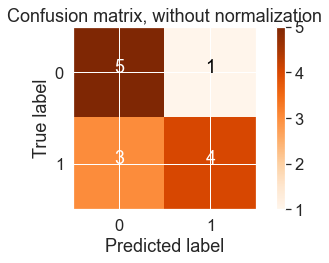

In [72]:
for i in range(ind_fs+1):
    plot_confusion_matrix(fs_pred[ind_fs-1][i], fs_act[ind_fs-1][i])

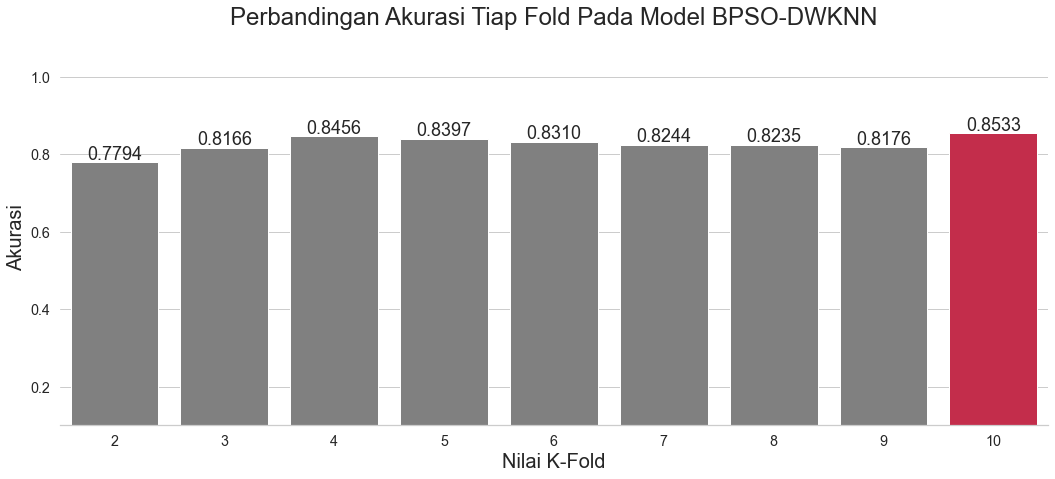

In [192]:
fold = [2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize=(15,7))
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
clr = ['grey' if (x < max(fs_acc[1:10])) else 'crimson' for x in fs_acc[1:10]]
p = sns.barplot(x=fold, y=fs_acc[1:10], palette=clr)
sns.despine(left=True)
p.set_title('Perbandingan Akurasi Tiap Fold Pada Model BPSO-DWKNN', fontsize=24, y=1.05)
p.set_xlabel("Nilai K-Fold", fontsize = 20)
p.set_ylabel("Akurasi", fontsize = 20)
p.set_ylim(0.1, 1.07)
sns.set(font_scale=1.5)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/FoldWithBPSO.png')

In [74]:
fld = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]
fold_fs_df = pd.DataFrame({'Fold': fld[1:10],
                       'AkurasiTrain': np.round(fs_mdl[1:10], 4),
                      'AkurasiTest': np.round(fs_acc[1:10], 4),
                      'Presisi': np.round(fs_prc[1:10], 4),
                      'Recall': np.round(fs_rcl[1:10], 4),
                      'F1-Score': np.round(fs_f1[1:10], 4),
                           'JumlahFitur': ftr[1:10],
                      })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

fold_fs_df.style.set_table_styles(dfstyle).hide_index()

In [193]:
fs_pos_df = pd.DataFrame(fs_pos)
fs_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/ProstateFoldPOS.csv')

## Pembagian Data

In [96]:
X_train = X_train_fold[ind_fs-1]
y_train = y_train_fold[ind_fs-1] 
X_test =  X_test_fold[ind_fs-1]
y_test = y_test_fold[ind_fs-1]

print(len(X_train), len(y_train), len(X_test), len(y_test))

10 10 10 10


## C1, C2, W

In [77]:
#modeling
model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')
splits = ind_fs+1

#seleksi fitur BPSO
def f_per_particle(m, alpha):
    total_features = X.shape[1]
    scores = np.zeros(splits)

    for i in range(splits):
        if np.count_nonzero(m) == 0:
            X_subset = X_train[i]
        else:
            X_subset = X_train[i][:,m==1]

        model.fit(X_subset, y_train[i])
        pred = model.predict(X_subset)
        scores[i] = accuracy_score(y_train[i], pred)

    P = np.mean(scores)

    j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

def f(x, alpha=0.88):
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

w = 0.9
c1 = [1, 1.25, 1.5, 1.75, 2]
c2 = [1, 1.25, 1.5, 1.75, 2]
wth, hgh = 5, 5
w0_acc = [[0 for x in range(wth)] for y in range(hgh)] 
w1_acc = [[0 for x in range(wth)] for y in range(hgh)] 
c1c2_pos = []
for it in range(2):
    m = 0
    for _c1 in range(len(c1)):
        n = 0
        for _c2 in range(len(c2)):
                #inisiasiBPSO
                ps.discrete.BinaryPSO

                #executeBPSO
                options = {'c1': c1[_c1], 'c2': c2[_c2], 'w':w, 'k': 30, 'p':2}
                dimensions = X.shape[1]
                optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
                cost, pos = optimizer.optimize(f, iters=10, verbose=3)
                
                c1c2_pos.append(pos)

                #model
                model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

                mdl_scr = np.zeros(splits)
                acc_scr = np.zeros(splits)
                prc_scr = np.zeros(splits)
                rcl_scr = np.zeros(splits)
                f1_scr = np.zeros(splits)

                for i in range(splits):
                    X_train_selected = X_train[i][:,pos==1]
                    X_test_selected = X_test[i][:,pos==1]

                    #fit
                    model.fit(X_train_selected, y_train[i])

                    #predict
                    pred = model.predict(X_test_selected)

                    #accuracy
                    mdl_scr[i] = model.score(X_train_selected, y_train[i])
                    acc_scr[i] = accuracy_score(y_test[i], pred)
                    prc_scr[i] = precision_score(y_test[i], pred, pos_label=1)
                    rcl_scr[i] = recall_score(y_test[i], pred, pos_label=1)
                    f1_scr[i] = f1_score(y_test[i], pred, pos_label=1)
                if w == 0.9:
                    w0_acc[m][n] = np.round(np.mean(acc_scr), 4)
                else:
                    w1_acc[m][n] = np.round(np.mean(acc_scr), 4)
                n+=1
                print('c1 = ', c1[_c1], 'c2 = ', c2[_c2], 'w = ', w)
                print('Dengan Seleksi Fitur BPSO')
                print('Model:', np.round(np.mean(mdl_scr),4), '\t', 'Acc: ', np.round(np.mean(acc_scr),4), '\t', 'Presisi: ', np.round(np.mean(prc_scr),4), '\t', 'Recall:', np.round(np.mean(rcl_scr),4), '\t', 'F1 Score:', np.round(np.mean(f1_scr),4), '\t', 'Fitur Terpilih:', np.count_nonzero(pos))
        m+=1
    w+=0.1

2022-07-18 18:16:24,949 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-18 18:17:39,045 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057780952380952384, best pos: [0 0 1 ... 0 0 1]
2022-07-18 18:17:39,484 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8324 	 Presisi:  0.8889 	 Recall: 0.8054 	 F1 Score: 0.8431 	 Fitur Terpilih: 6533


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-18 18:18:53,362 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05788571428571428, best pos: [1 1 0 ... 1 1 1]
2022-07-18 18:18:53,782 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8527 	 Presisi:  0.8774 	 Recall: 0.8679 	 F1 Score: 0.8657 	 Fitur Terpilih: 6522


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-18 18:20:08,130 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05814285714285715, best pos: [0 1 1 ... 1 1 0]
2022-07-18 18:20:08,555 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8308 	 Presisi:  0.8554 	 Recall: 0.8554 	 F1 Score: 0.8474 	 Fitur Terpilih: 6495


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-18 18:21:23,162 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05793333333333333, best pos: [1 1 1 ... 1 1 1]
2022-07-18 18:21:23,593 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8538 	 Presisi:  0.8874 	 Recall: 0.8554 	 F1 Score: 0.8668 	 Fitur Terpilih: 6517


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-18 18:22:32,515 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057904761904761896, best pos: [0 0 1 ... 0 0 0]
2022-07-18 18:22:32,805 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8236 	 Presisi:  0.8578 	 Recall: 0.8286 	 F1 Score: 0.8376 	 Fitur Terpilih: 6520


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0583
2022-07-18 18:23:25,813 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05830476190476191, best pos: [1 0 0 ... 1 0 1]
2022-07-18 18:23:26,098 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8093 	 Presisi:  0.8453 	 Recall: 0.8161 	 F1 Score: 0.8247 	 Fitur Terpilih: 6478


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-18 18:24:32,975 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05807619047619047, best pos: [0 0 0 ... 1 1 1]
2022-07-18 18:24:33,389 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8462 	 Presisi:  0.8717 	 Recall: 0.8554 	 F1 Score: 0.8575 	 Fitur Terpilih: 6502


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-18 18:25:50,689 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05816190476190476, best pos: [1 0 1 ... 1 1 0]
2022-07-18 18:25:51,105 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8604 	 Presisi:  0.8838 	 Recall: 0.8679 	 F1 Score: 0.8712 	 Fitur Terpilih: 6493


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 18:27:04,990 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05802857142857142, best pos: [1 1 0 ... 1 0 1]
2022-07-18 18:27:05,385 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8676 	 Presisi:  0.9092 	 Recall: 0.8554 	 F1 Score: 0.8753 	 Fitur Terpilih: 6507


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-18 18:28:16,174 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05751428571428571, best pos: [0 1 0 ... 0 0 0]
2022-07-18 18:28:16,586 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8538 	 Presisi:  0.8777 	 Recall: 0.8679 	 F1 Score: 0.8675 	 Fitur Terpilih: 6561


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 18:29:31,141 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058038095238095236, best pos: [0 1 1 ... 1 0 1]
2022-07-18 18:29:31,553 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8308 	 Presisi:  0.8685 	 Recall: 0.8304 	 F1 Score: 0.841 	 Fitur Terpilih: 6506


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 18:30:44,956 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057980952380952376, best pos: [1 1 1 ... 1 0 0]
2022-07-18 18:30:45,369 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8236 	 Presisi:  0.8504 	 Recall: 0.8411 	 F1 Score: 0.8401 	 Fitur Terpilih: 6512


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 18:31:59,007 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05759047619047619, best pos: [1 1 0 ... 0 1 1]
2022-07-18 18:31:59,424 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8242 	 Presisi:  0.8574 	 Recall: 0.8286 	 F1 Score: 0.8376 	 Fitur Terpilih: 6553


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-18 18:33:12,373 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05784761904761905, best pos: [1 0 0 ... 0 1 0]
2022-07-18 18:33:12,782 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8396 	 Presisi:  0.8737 	 Recall: 0.8429 	 F1 Score: 0.8535 	 Fitur Terpilih: 6526


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-18 18:34:23,670 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058123809523809515, best pos: [0 0 1 ... 0 1 1]
2022-07-18 18:34:23,957 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8319 	 Presisi:  0.8574 	 Recall: 0.8429 	 F1 Score: 0.8455 	 Fitur Terpilih: 6497


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0583
2022-07-18 18:35:31,914 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05834285714285714, best pos: [1 1 0 ... 0 1 0]
2022-07-18 18:35:32,369 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8236 	 Presisi:  0.8838 	 Recall: 0.8018 	 F1 Score: 0.8352 	 Fitur Terpilih: 6474


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-18 18:36:46,511 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0578952380952381, best pos: [0 1 0 ... 1 1 1]
2022-07-18 18:36:46,923 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8467 	 Presisi:  0.8763 	 Recall: 0.8554 	 F1 Score: 0.8609 	 Fitur Terpilih: 6521


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 18:37:56,846 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05802857142857142, best pos: [0 0 1 ... 0 0 0]
2022-07-18 18:37:57,268 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8242 	 Presisi:  0.8598 	 Recall: 0.8286 	 F1 Score: 0.8401 	 Fitur Terpilih: 6507


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-18 18:39:09,695 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057904761904761896, best pos: [1 1 1 ... 1 1 0]
2022-07-18 18:39:10,097 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8379 	 Presisi:  0.8723 	 Recall: 0.8411 	 F1 Score: 0.8508 	 Fitur Terpilih: 6520


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-18 18:40:23,547 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05817142857142857, best pos: [0 1 1 ... 0 1 1]
2022-07-18 18:40:24,008 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8467 	 Presisi:  0.8749 	 Recall: 0.8554 	 F1 Score: 0.8602 	 Fitur Terpilih: 6492


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 18:41:37,312 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057971428571428577, best pos: [1 0 0 ... 0 0 1]
2022-07-18 18:41:37,742 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8462 	 Presisi:  0.8852 	 Recall: 0.8411 	 F1 Score: 0.8584 	 Fitur Terpilih: 6513


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-18 18:42:52,547 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05824761904761904, best pos: [1 1 0 ... 1 0 1]
2022-07-18 18:42:52,971 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8093 	 Presisi:  0.8355 	 Recall: 0.8304 	 F1 Score: 0.8282 	 Fitur Terpilih: 6484


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-18 18:43:54,786 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05709523809523809, best pos: [0 1 1 ... 1 1 0]
2022-07-18 18:43:55,094 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8308 	 Presisi:  0.8554 	 Recall: 0.8536 	 F1 Score: 0.846 	 Fitur Terpilih: 6605


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-18 18:45:07,228 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05785714285714285, best pos: [0 1 0 ... 1 0 1]
2022-07-18 18:45:07,631 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8462 	 Presisi:  0.8723 	 Recall: 0.8554 	 F1 Score: 0.8586 	 Fitur Terpilih: 6525


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-18 18:46:21,885 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057704761904761905, best pos: [1 0 0 ... 1 0 1]
2022-07-18 18:46:22,297 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8462 	 Presisi:  0.8727 	 Recall: 0.8554 	 F1 Score: 0.8595 	 Fitur Terpilih: 6541


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-18 18:47:36,502 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058133333333333335, best pos: [1 1 1 ... 0 1 1]
2022-07-18 18:47:36,919 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8385 	 Presisi:  0.8554 	 Recall: 0.8679 	 F1 Score: 0.855 	 Fitur Terpilih: 6496


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 18:48:56,700 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05758095238095238, best pos: [1 0 1 ... 0 1 1]
2022-07-18 18:48:57,095 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8462 	 Presisi:  0.8848 	 Recall: 0.8429 	 F1 Score: 0.8576 	 Fitur Terpilih: 6554


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0583
2022-07-18 18:49:55,006 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05825714285714286, best pos: [0 1 1 ... 1 0 1]
2022-07-18 18:49:55,301 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8165 	 Presisi:  0.8318 	 Recall: 0.8554 	 F1 Score: 0.8374 	 Fitur Terpilih: 6483


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-18 18:50:51,540 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05788571428571428, best pos: [0 1 1 ... 0 1 1]
2022-07-18 18:50:51,913 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8231 	 Presisi:  0.8527 	 Recall: 0.8393 	 F1 Score: 0.8385 	 Fitur Terpilih: 6522


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 18:51:46,727 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05795238095238094, best pos: [1 1 0 ... 0 0 1]
2022-07-18 18:51:47,022 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8456 	 Presisi:  0.8732 	 Recall: 0.8554 	 F1 Score: 0.86 	 Fitur Terpilih: 6515


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-18 18:52:42,537 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058123809523809515, best pos: [0 0 1 ... 0 1 0]
2022-07-18 18:52:42,843 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8533 	 Presisi:  0.8744 	 Recall: 0.8679 	 F1 Score: 0.867 	 Fitur Terpilih: 6497


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0583
2022-07-18 18:53:38,535 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05834285714285714, best pos: [1 0 0 ... 0 1 1]
2022-07-18 18:53:38,821 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8533 	 Presisi:  0.874 	 Recall: 0.8679 	 F1 Score: 0.8661 	 Fitur Terpilih: 6474


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 18:54:46,046 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05795238095238094, best pos: [0 0 1 ... 0 1 1]
2022-07-18 18:54:46,465 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8236 	 Presisi:  0.8695 	 Recall: 0.8143 	 F1 Score: 0.8363 	 Fitur Terpilih: 6515


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-18 18:56:00,803 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057723809523809524, best pos: [1 0 1 ... 1 1 1]
2022-07-18 18:56:01,237 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8313 	 Presisi:  0.8759 	 Recall: 0.8286 	 F1 Score: 0.8447 	 Fitur Terpilih: 6539


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 18:57:10,987 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05742857142857142, best pos: [0 0 1 ... 1 1 0]
2022-07-18 18:57:11,299 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8165 	 Presisi:  0.8572 	 Recall: 0.8143 	 F1 Score: 0.8293 	 Fitur Terpilih: 6570


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-18 18:58:18,896 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057647619047619045, best pos: [0 1 0 ... 1 0 0]
2022-07-18 18:58:19,352 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8456 	 Presisi:  0.8709 	 Recall: 0.8536 	 F1 Score: 0.8577 	 Fitur Terpilih: 6547


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-18 18:59:36,037 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05808571428571428, best pos: [1 0 0 ... 1 1 1]
2022-07-18 18:59:36,462 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8313 	 Presisi:  0.862 	 Recall: 0.8411 	 F1 Score: 0.8466 	 Fitur Terpilih: 6501


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-18 19:00:49,600 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05820952380952381, best pos: [0 1 1 ... 1 0 0]
2022-07-18 19:00:49,884 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8165 	 Presisi:  0.8485 	 Recall: 0.8286 	 F1 Score: 0.8314 	 Fitur Terpilih: 6488


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-18 19:02:03,189 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0578, best pos: [1 1 0 ... 1 0 1]
2022-07-18 19:02:03,597 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8236 	 Presisi:  0.862 	 Recall: 0.8268 	 F1 Score: 0.8376 	 Fitur Terpilih: 6531


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 19:03:17,266 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05743809523809524, best pos: [1 0 0 ... 0 1 0]
2022-07-18 19:03:17,674 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.839 	 Presisi:  0.8554 	 Recall: 0.8679 	 F1 Score: 0.8557 	 Fitur Terpilih: 6569


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-18 19:04:14,509 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058190476190476195, best pos: [0 1 1 ... 0 1 1]
2022-07-18 19:04:14,808 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}


c1 =  1.75 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8604 	 Presisi:  0.8959 	 Recall: 0.8536 	 F1 Score: 0.8693 	 Fitur Terpilih: 6490


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-18 19:05:06,610 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0578952380952381, best pos: [1 0 1 ... 1 0 1]
2022-07-18 19:05:06,897 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8379 	 Presisi:  0.8615 	 Recall: 0.8536 	 F1 Score: 0.8527 	 Fitur Terpilih: 6521


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0573
2022-07-18 19:05:58,588 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05731428571428571, best pos: [0 1 0 ... 0 0 0]
2022-07-18 19:05:58,900 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8462 	 Presisi:  0.8663 	 Recall: 0.8679 	 F1 Score: 0.8615 	 Fitur Terpilih: 6582


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-18 19:06:50,522 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05736190476190476, best pos: [0 0 1 ... 1 1 1]
2022-07-18 19:06:50,811 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8159 	 Presisi:  0.8417 	 Recall: 0.8286 	 F1 Score: 0.8314 	 Fitur Terpilih: 6577


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-18 19:07:42,039 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05791428571428571, best pos: [1 0 0 ... 0 0 1]
2022-07-18 19:07:42,343 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8538 	 Presisi:  0.8777 	 Recall: 0.8679 	 F1 Score: 0.8675 	 Fitur Terpilih: 6519


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 19:08:54,475 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057961904761904756, best pos: [1 0 1 ... 1 0 0]
2022-07-18 19:08:54,882 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8538 	 Presisi:  0.8842 	 Recall: 0.8554 	 F1 Score: 0.8642 	 Fitur Terpilih: 6514


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-18 19:10:09,924 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0578, best pos: [0 0 0 ... 1 0 0]
2022-07-18 19:10:10,316 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}


c1 =  2 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8379 	 Presisi:  0.8615 	 Recall: 0.8536 	 F1 Score: 0.8527 	 Fitur Terpilih: 6531


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0583
2022-07-18 19:11:27,143 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05825714285714286, best pos: [1 0 0 ... 0 1 1]
2022-07-18 19:11:27,585 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8319 	 Presisi:  0.8745 	 Recall: 0.8286 	 F1 Score: 0.8444 	 Fitur Terpilih: 6483


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-18 19:12:43,183 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05751428571428571, best pos: [0 0 1 ... 1 1 0]
2022-07-18 19:12:43,611 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8022 	 Presisi:  0.8713 	 Recall: 0.775 	 F1 Score: 0.8134 	 Fitur Terpilih: 6561


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-18 19:14:01,502 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05765714285714286, best pos: [0 1 1 ... 1 1 0]


c1 =  2 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8319 	 Presisi:  0.8549 	 Recall: 0.8554 	 F1 Score: 0.849 	 Fitur Terpilih: 6546


In [78]:
w0_df = pd.DataFrame(w0_acc)
w0_df.columns = ['1', '1.25', '1.5', '1.75', '2']
w0_df.index = ['1', '1.25', '1.5', '1.75', '2']

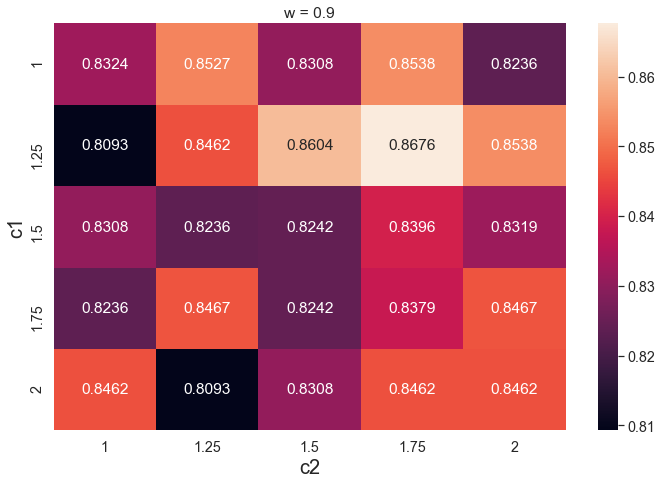

In [194]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
par_w0 = sns.heatmap(xticklabels=c2, yticklabels=c1, data=w0_acc, annot=True, fmt='.4f')
ft = {
    'fontsize':20,
    'fontweight':20,
}
par_w0.set_title(label= 'w = 0.9');
par_w0.set_xlabel('c2', fontdict=ft)
par_w0.set_ylabel('c1', fontdict=ft)
p_fig = par_w0.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/C1C2W09.png')

In [80]:
# w0_acc.reverse()

In [81]:
w1_df = pd.DataFrame(w1_acc)
w1_df.columns = ['1', '1.25', '1.5', '1.75', '2']
w1_df.index = ['1', '1.25', '1.5', '1.75', '2']

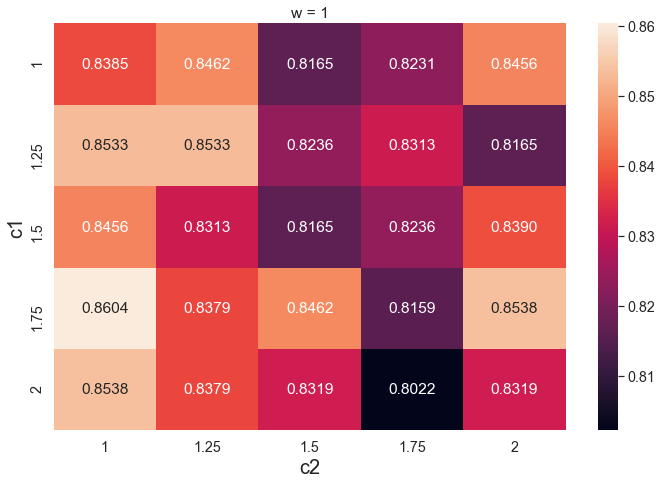

In [195]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
par_w1 = sns.heatmap(xticklabels=c2, yticklabels=c1, data=w1_acc, annot=True, fmt='.4f')
ft = {
    'fontsize':20,
    'fontweight':20,
}
par_w1.set_title(label= 'w = 1');
par_w1.set_xlabel('c2', fontdict=ft)
par_w1.set_ylabel('c1', fontdict=ft)
p_fig = par_w1.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/C1C2W1.png')

In [28]:
# w1_acc.reverse()

In [196]:
c1c2_pos_df = pd.DataFrame(c1c2_pos)
c1c2_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/ProstateC1C2POS.csv')

## Population

In [146]:
#modeling
model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

#seleksi fitur BPSO
def f_per_particle(m, alpha):
    total_features = X.shape[1]
    scores = np.zeros(splits)

    for i in range(splits):
        if np.count_nonzero(m) == 0:
            X_subset = X_train[i]
        else:
            X_subset = X_train[i][:,m==1]

        model.fit(X_subset, y_train[i])
        pred = model.predict(X_subset)
        scores[i] = accuracy_score(y_train[i], pred)

    P = np.mean(scores)

    j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

def f(x, alpha=0.88):
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

prt = [10, 20, 30, 50]

pop_mdl = np.zeros(len(prt))
pop_acc = np.zeros(len(prt))
pop_prc = np.zeros(len(prt))
pop_rcl = np.zeros(len(prt))
pop_f1 = np.zeros(len(prt))
pop_pos = []

for k in range(len(prt)):
    #inisiasiBPSO
    ps.discrete.BinaryPSO

    #executeBPSO
    options = {'c1': 1.25, 'c2': 1.75, 'w': 0.9, 'k': prt[k], 'p':2}
    dimensions = X.shape[1]
    optimizer = ps.discrete.BinaryPSO(n_particles=prt[k], dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
    cost, pos = optimizer.optimize(f, iters=10, verbose=3)

    pop_pos.append(pos)

    #model
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    mdl_scr = np.zeros(splits)
    acc_scr = np.zeros(splits)
    prc_scr = np.zeros(splits)
    rcl_scr = np.zeros(splits)
    f1_scr = np.zeros(splits)

    for i in range(splits):
        X_train_selected = X_train[i][:,pos==1]
        X_test_selected = X_test[i][:,pos==1]

        #fit
        model.fit(X_train_selected, y_train[i])

        #predict
        pred = model.predict(X_test_selected)

        #accuracy
        mdl_scr[i] = model.score(X_train_selected, y_train[i])
        acc_scr[i] = accuracy_score(y_test[i], pred)
        prc_scr[i] = precision_score(y_test[i], pred, pos_label=1)
        rcl_scr[i] = recall_score(y_test[i], pred, pos_label=1)
        f1_scr[i] = f1_score(y_test[i], pred, pos_label=1)

    pop_mdl[k] = np.mean(mdl_scr)
    pop_acc[k] = np.mean(acc_scr)
    pop_prc[k] = np.mean(prc_scr)
    pop_rcl[k] = np.mean(rcl_scr)
    pop_f1[k] = np.mean(f1_scr)   

    print('Population:', prt[k])
    print('Dengan Seleksi Fitur BPSO')
    print('Model:', np.round(np.mean(mdl_scr),4), '\t', 'Acc: ', np.round(np.mean(acc_scr),4), '\t', 'Presisi: ', np.round(np.mean(prc_scr),4), '\t', 'Recall:', np.round(np.mean(rcl_scr),4), '\t', 'F1 Score:', np.round(np.mean(f1_scr),4), '\t', 'Fitur Terpilih:', np.count_nonzero(pos))

2022-07-18 21:47:14,346 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 0.9, 'k': 10, 'p': 2}
pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-18 21:47:34,101 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05804761904761904, best pos: [1 0 1 ... 0 1 1]
2022-07-18 21:47:34,476 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 0.9, 'k': 20, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 10
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8462 	 Presisi:  0.8649 	 Recall: 0.8679 	 F1 Score: 0.8608 	 Fitur Terpilih: 6505


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-18 21:48:13,935 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05820952380952381, best pos: [1 1 1 ... 0 1 1]
2022-07-18 21:48:14,296 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 20
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8538 	 Presisi:  0.8777 	 Recall: 0.8679 	 F1 Score: 0.8675 	 Fitur Terpilih: 6488


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 21:49:20,766 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057238095238095234, best pos: [0 0 1 ... 1 0 1]
2022-07-18 21:49:21,220 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 0.9, 'k': 50, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 30
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8456 	 Presisi:  0.8643 	 Recall: 0.8679 	 F1 Score: 0.8602 	 Fitur Terpilih: 6590


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-18 21:51:30,967 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057219047619047614, best pos: [0 1 0 ... 1 0 0]


Population: 50
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.8681 	 Presisi:  0.8913 	 Recall: 0.8804 	 F1 Score: 0.8807 	 Fitur Terpilih: 6592


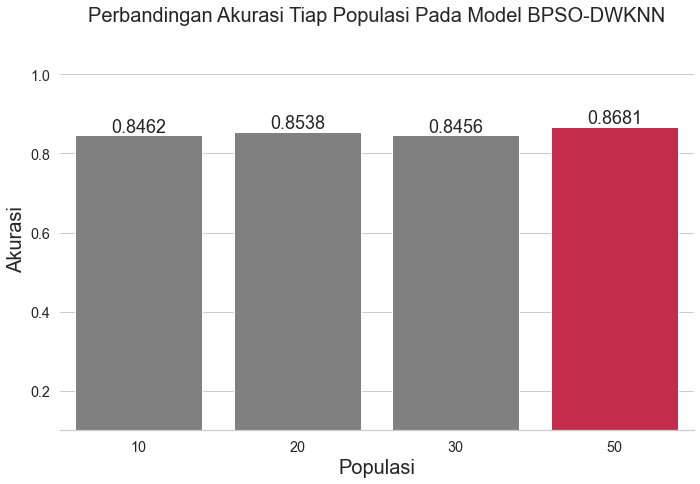

In [197]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
clr = ['grey' if (x < max(pop_acc)) else 'crimson' for x in pop_acc]
p = sns.barplot(x=prt, y=pop_acc, palette=clr)
p.set_title('Perbandingan Akurasi Tiap Populasi Pada Model BPSO-DWKNN', fontsize=20, y=1.05)
sns.despine(left=True)
p.set_xlabel("Populasi", fontsize = 20)
p.set_ylabel("Akurasi", fontsize = 20)
p.set_ylim(0.1, 1.07)
sns.set(font_scale=1.3)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Populasi.png')

In [148]:
pop = [10, 20, 30, 50]
pop_ftr = [np.count_nonzero(pop_pos[0]), np.count_nonzero(pop_pos[1]), np.count_nonzero(pop_pos[2]), np.count_nonzero(pop_pos[3])]
pop_df = pd.DataFrame({'Populasi': pop,
                       'AkurasiTrain': np.round(pop_mdl, 4),
                      'AkurasiTest': np.round(pop_acc, 4),
                      'Presisi': np.round(pop_prc, 4),
                      'Recall': np.round(pop_rcl, 4),
                      'F1-Score': np.round(pop_f1, 4),
                       'JumlahFitur': pop_ftr,
                      })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

pop_df.style.set_table_styles(dfstyle).hide_index()

In [198]:
pop_pos_df = pd.DataFrame(pop_pos)
pop_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/ProstatePopPOS.csv')

In [199]:
col = df.columns[1:].values
fitur_df = pd.DataFrame(col[pop_pos[3]==1])
fitur_n_df = pd.DataFrame(col[pop_pos[3]==0])
fitur_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/Prostate(FiturTerpilih).csv')
fitur_n_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/Prostate(FiturDihapus).csv')

# KLASIFIKASI

In [200]:
kfld_mdl = []
kfld_acc = []
kfld_prc = []
kfld_rcl = []
kfld_f1 = []
kfld_pred = []
kfld_act = []

kfld_d_mdl = []
kfld_d_acc = []
kfld_d_prc = []
kfld_d_rcl = []
kfld_d_f1 = []
kfld_d_pred = []
kfld_d_act = []

In [201]:
print(np.argmax(pop_acc))

for a in range(9):
    print("FOLD :", a+2)
    X_train = X_train_fold[a]
    y_train = y_train_fold[a] 
    X_test =  X_test_fold[a]
    y_test = y_test_fold[a]

    print(len(X_train), len(y_train), len(X_test), len(y_test))
    
    range_k0 = []

    kf_mdl = []
    kf_acc = []
    kf_prc = []
    kf_rcl = []
    kf_f1 = []
    kf_pred = []
    kf_act = []

    kfd_mdl = []
    kfd_acc = []
    kfd_prc = []
    kfd_rcl = []
    kfd_f1 = []
    kfd_pred = []
    kfd_act = []

    for k in range(1, 21):
        
        range_k0.append(k)
        model = DistanceWeightedKNN(n_neighbors=k, algorithm='brute')
        
        # BPSO-DWKNN
        mdl_scr = np.zeros(a+2)
        acc_scr = np.zeros(a+2)
        prc_scr = np.zeros(a+2)
        rcl_scr = np.zeros(a+2)
        f1_scr = np.zeros(a+2)
        
        pred_scr = []
        act_scr = []
        for i in range(a+2):
            X_train_selected = X_train[i][:,pop_pos[np.argmax(pop_acc)]==1]
            X_test_selected = X_test[i][:,pop_pos[np.argmax(pop_acc)]==1]

            #fit
            model.fit(X_train_selected, y_train[i])

            #predict
            pred = model.predict(X_test_selected)
            pred_scr.append(pred)
            act_scr.append(y_test[i])

            #accuracy
            mdl_scr[i] = model.score(X_train_selected, y_train[i])
            acc_scr[i] = accuracy_score(y_test[i], pred)
            prc_scr[i] = precision_score(y_test[i], pred, pos_label=1)
            rcl_scr[i] = recall_score(y_test[i], pred, pos_label=1)
            f1_scr[i] = f1_score(y_test[i], pred, pos_label=1)
        
        # DWKNN
        _mdl_scr = np.zeros(a+2)
        _acc_scr = np.zeros(a+2)
        _prc_scr = np.zeros(a+2)
        _rcl_scr = np.zeros(a+2)
        _f1_scr = np.zeros(a+2)
            
        _pred_scr = []
        _act_scr = []
        for i in range(a+2):
            #fit
            model.fit(X_train[i], y_train[i])

            #predict
            pred = model.predict(X_test[i])
            _pred_scr.append(pred)
            _act_scr.append(y_test[i])

            #accuracy
            _mdl_scr[i] = model.score(X_train[i], y_train[i])
            _acc_scr[i] = accuracy_score(y_test[i], pred)
            _prc_scr[i] = precision_score(y_test[i], pred, pos_label=1)
            _rcl_scr[i] = recall_score(y_test[i], pred, pos_label=1)
            _f1_scr[i] = f1_score(y_test[i], pred, pos_label=1)

        # BPSO-DWKNN
        kf_mdl.append(np.round(np.mean(mdl_scr),4))
        kf_acc.append(np.round(np.mean(acc_scr),4))
        kf_prc.append(np.round(np.mean(prc_scr),4))
        kf_rcl.append(np.round(np.mean(rcl_scr),4))
        kf_f1.append(np.round(np.mean(f1_scr),4))
        kf_pred.append(pred_scr)
        kf_act.append(act_scr)

        # DWKNN
        kfd_mdl.append(np.round(np.mean(_mdl_scr),4))
        kfd_acc.append(np.round(np.mean(_acc_scr),4))
        kfd_prc.append(np.round(np.mean(_prc_scr),4))
        kfd_rcl.append(np.round(np.mean(_rcl_scr),4))
        kfd_f1.append(np.round(np.mean(_f1_scr),4))
        kfd_pred.append(_pred_scr)
        kfd_act.append(_act_scr)
    print(len(kfld_acc))
    if len(kfld_acc) < 9:
        # BPSO-DWKNN 
        kfld_mdl.append(kf_mdl)
        kfld_acc.append(kf_acc)
        kfld_prc.append(kf_prc)
        kfld_rcl.append(kf_rcl)
        kfld_f1.append(kf_f1)
        kfld_pred.append(kf_pred)
        kfld_act.append(kf_act)

        # DWKNN
        kfld_d_mdl.append(kfd_mdl)
        kfld_d_acc.append(kfd_acc)
        kfld_d_prc.append(kfd_prc)
        kfld_d_rcl.append(kfd_rcl)
        kfld_d_f1.append(kfd_f1)
        kfld_d_pred.append(kfd_pred)
        kfld_d_act.append(kfd_act)
    else:
        for z in range(len(kf_mdl)):
            # BPSO-DWKNN 
            kfld_mdl[a].append(kf_mdl[z])
            kfld_acc[a].append(kf_acc[z])
            kfld_prc[a].append(kf_prc[z])
            kfld_rcl[a].append(kf_rcl[z])
            kfld_f1[a].append(kf_f1[z])
            kfld_pred[a].append(kf_pred[z])
            kfld_act[a].append(kf_act[z])

            # DWKNN
            kfld_d_mdl[a].append(kfd_mdl[z])
            kfld_d_acc[a].append(kfd_acc[z])
            kfld_d_prc[a].append(kfd_prc[z])
            kfld_d_rcl[a].append(kfd_rcl[z])
            kfld_d_f1[a].append(kfd_f1[z])
            kfld_d_pred[a].append(kfd_pred[z])
            kfld_d_act[a].append(kfd_act[z])

3
FOLD : 2
2 2 2 2
0
FOLD : 3
3 3 3 3
1
FOLD : 4
4 4 4 4
2
FOLD : 5
5 5 5 5
3
FOLD : 6
6 6 6 6
4
FOLD : 7
7 7 7 7
5
FOLD : 8
8 8 8 8
6
FOLD : 9
9 9 9 9
7
FOLD : 10
10 10 10 10
8


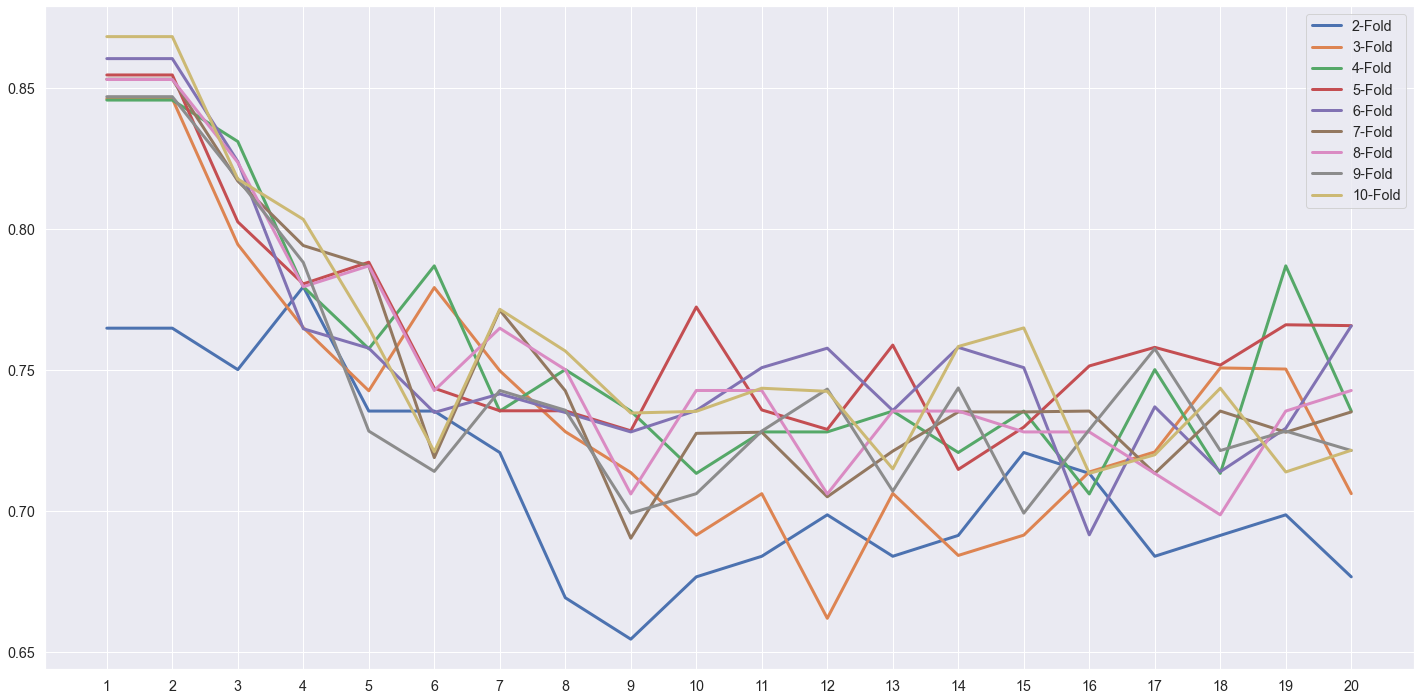

In [203]:
plt.figure(figsize=(20,10))
for i in range(9):
    p = sns.lineplot(range_k0, kfld_acc[i], label='{}-Fold'.format(i+2), linewidth=3)
    p.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [204]:
val_k = []

max_mdl = []
max_akr = []
max_prc = []
max_rcl = []
max_f1 = []
for i in range(9):
    print('FOLD:', i+2, '\t K:', np.argmax(kfld_acc[i])+1, '\t ACC:', np.max(kfld_acc[i]), '\t JUMLAH FITUR:', (np.count_nonzero(pop_pos[np.argmax(pop_acc)])))
    val_k.append(np.argmax(kfld_acc[i])+1)
    max_mdl.append(kfld_mdl[i][np.argmax(kfld_acc[i])])
    max_akr.append(np.max(kfld_acc[i]))
    max_prc.append(kfld_prc[i][np.argmax(kfld_acc[i])])
    max_rcl.append(kfld_rcl[i][np.argmax(kfld_acc[i])])
    max_f1.append(kfld_f1[i][np.argmax(kfld_acc[i])])

FOLD: 2 	 K: 4 	 ACC: 0.7794 	 JUMLAH FITUR: 6592
FOLD: 3 	 K: 1 	 ACC: 0.8461 	 JUMLAH FITUR: 6592
FOLD: 4 	 K: 1 	 ACC: 0.8456 	 JUMLAH FITUR: 6592
FOLD: 5 	 K: 1 	 ACC: 0.8545 	 JUMLAH FITUR: 6592
FOLD: 6 	 K: 1 	 ACC: 0.8603 	 JUMLAH FITUR: 6592
FOLD: 7 	 K: 1 	 ACC: 0.853 	 JUMLAH FITUR: 6592
FOLD: 8 	 K: 1 	 ACC: 0.8529 	 JUMLAH FITUR: 6592
FOLD: 9 	 K: 1 	 ACC: 0.8468 	 JUMLAH FITUR: 6592
FOLD: 10 	 K: 1 	 ACC: 0.8681 	 JUMLAH FITUR: 6592


In [242]:
print(kfld_acc[1][0], kfld_prc[1][0], kfld_rcl[1][0], kfld_f1[1][0])
print(kfld_acc[1][1], kfld_prc[1][1], kfld_rcl[1][1], kfld_f1[1][1])
print('===================================')
print(kfld_acc[2][0], kfld_prc[2][0], kfld_rcl[2][0], kfld_f1[2][0])
print(kfld_acc[2][1], kfld_prc[2][1], kfld_rcl[2][1], kfld_f1[2][1])
print('===================================')
print(kfld_acc[3][0], kfld_prc[3][0], kfld_rcl[3][0], kfld_f1[3][0])
print(kfld_acc[3][1], kfld_prc[3][1], kfld_rcl[3][1], kfld_f1[3][1])
print('===================================')
print(kfld_acc[4][0], kfld_prc[4][0], kfld_rcl[4][0], kfld_f1[4][0])
print(kfld_acc[4][1], kfld_prc[4][1], kfld_rcl[4][1], kfld_f1[4][1])
print('===================================')
print(kfld_acc[5][0], kfld_prc[5][0], kfld_rcl[5][0], kfld_f1[5][0])
print(kfld_acc[5][1], kfld_prc[5][1], kfld_rcl[5][1], kfld_f1[5][1])
print('===================================')
print(kfld_acc[6][0], kfld_prc[6][0], kfld_rcl[6][0], kfld_f1[6][0])
print(kfld_acc[6][1], kfld_prc[6][1], kfld_rcl[6][1], kfld_f1[6][1])
print('===================================')
print(kfld_acc[7][0], kfld_prc[7][0], kfld_rcl[7][0], kfld_f1[7][0])
print(kfld_acc[7][1], kfld_prc[7][1], kfld_rcl[7][1], kfld_f1[7][1])
print('===================================')
print(kfld_acc[8][0], kfld_prc[8][0], kfld_rcl[8][0], kfld_f1[8][0])
print(kfld_acc[8][1], kfld_prc[8][1], kfld_rcl[8][1], kfld_f1[8][1])

0.8461 0.8496 0.8959 0.8696
0.8461 0.8496 0.8959 0.8696
0.8456 0.8561 0.8842 0.8681
0.8456 0.8561 0.8842 0.8681
0.8545 0.872 0.8833 0.8751
0.8545 0.872 0.8833 0.8751
0.8603 0.8729 0.8953 0.881
0.8603 0.8729 0.8953 0.881
0.853 0.8741 0.8831 0.8724
0.853 0.8741 0.8831 0.8724
0.8529 0.8737 0.8806 0.8704
0.8529 0.8737 0.8806 0.8704
0.8468 0.8758 0.8688 0.8646
0.8468 0.8758 0.8688 0.8646
0.8681 0.8913 0.8804 0.8807
0.8681 0.8913 0.8804 0.8807


In [205]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
bpdw_df = pd.DataFrame({'Fold': fld,
              'Nilai_K': val_k, 
              'AkurasiTrain': max_mdl,
              'AkurasiTest': max_akr,
              'Presisi': max_prc,
              'Recall': max_rcl,
              'F1_Score': max_f1,
              'Jumlah Fitur':(np.count_nonzero(pop_pos[np.argmax(pop_acc)]))
              })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

bpdw_df.style.set_table_styles(dfstyle).hide_index()

In [206]:
val_d_k = []

max_d_mdl = []
max_d_akr = []
max_d_prc = []
max_d_rcl = []
max_d_f1 = []
for i in range(9):
    print('FOLD:', i+2, 'K:', np.argmax(kfld_d_acc[i])+1, 'ACC:', np.max(kfld_d_acc[i]))
    val_d_k.append(np.argmax(kfld_d_acc[i])+1)
    max_d_mdl.append(kfld_d_mdl[i][np.argmax(kfld_d_acc[i])])
    max_d_akr.append(np.max(kfld_d_acc[i]))
    max_d_prc.append(kfld_d_prc[i][np.argmax(kfld_d_acc[i])])
    max_d_rcl.append(kfld_d_rcl[i][np.argmax(kfld_d_acc[i])])
    max_d_f1.append(kfld_d_f1[i][np.argmax(kfld_d_acc[i])])

FOLD: 2 K: 1 ACC: 0.7868
FOLD: 3 K: 1 ACC: 0.8312
FOLD: 4 K: 1 ACC: 0.8529
FOLD: 5 K: 1 ACC: 0.8471
FOLD: 6 K: 1 ACC: 0.831
FOLD: 7 K: 1 ACC: 0.8387
FOLD: 8 K: 1 ACC: 0.8382
FOLD: 9 K: 1 ACC: 0.8324
FOLD: 10 K: 1 ACC: 0.8533


In [241]:
print(kfld_d_acc[0][0], kfld_d_prc[0][0], kfld_d_rcl[0][0], kfld_d_f1[0][0])
print(kfld_d_acc[0][1], kfld_d_prc[0][1], kfld_d_rcl[0][1], kfld_d_f1[0][1])
print('===================================')
print(kfld_d_acc[1][0], kfld_d_prc[1][0], kfld_d_rcl[1][0], kfld_d_f1[1][0])
print(kfld_d_acc[1][1], kfld_d_prc[1][1], kfld_d_rcl[1][1], kfld_d_f1[1][1])
print('===================================')
print(kfld_d_acc[2][0], kfld_d_prc[2][0], kfld_d_rcl[2][0], kfld_d_f1[2][0])
print(kfld_d_acc[2][1], kfld_d_prc[2][1], kfld_d_rcl[2][1], kfld_d_f1[2][1])
print('===================================')
print(kfld_d_acc[3][0], kfld_d_prc[3][0], kfld_d_rcl[3][0], kfld_d_f1[3][0])
print(kfld_d_acc[3][1], kfld_d_prc[3][1], kfld_d_rcl[3][1], kfld_d_f1[3][1])
print('===================================')
print(kfld_d_acc[4][0], kfld_d_prc[4][0], kfld_d_rcl[4][0], kfld_d_f1[4][0])
print(kfld_d_acc[4][1], kfld_d_prc[4][1], kfld_d_rcl[4][1], kfld_d_f1[4][1])
print('===================================')
print(kfld_d_acc[5][0], kfld_d_prc[5][0], kfld_d_rcl[5][0], kfld_d_f1[5][0])
print(kfld_d_acc[5][1], kfld_d_prc[5][1], kfld_d_rcl[5][1], kfld_d_f1[5][1])
print('===================================')
print(kfld_d_acc[6][0], kfld_d_prc[6][0], kfld_d_rcl[6][0], kfld_d_f1[6][0])
print(kfld_d_acc[6][1], kfld_d_prc[6][1], kfld_d_rcl[6][1], kfld_d_f1[6][1])
print('===================================')
print(kfld_d_acc[7][0], kfld_d_prc[7][0], kfld_d_rcl[7][0], kfld_d_f1[7][0])
print(kfld_d_acc[7][1], kfld_d_prc[7][1], kfld_d_rcl[7][1], kfld_d_f1[7][1])
print('===================================')
print(kfld_d_acc[8][0], kfld_d_prc[8][0], kfld_d_rcl[8][0], kfld_d_f1[8][0])
print(kfld_d_acc[8][1], kfld_d_prc[8][1], kfld_d_rcl[8][1], kfld_d_f1[8][1])

0.7868 0.7929 0.8441 0.8177
0.7868 0.7929 0.8441 0.8177
0.8312 0.8341 0.8831 0.8566
0.8312 0.8341 0.8831 0.8566
0.8529 0.8575 0.8974 0.8756
0.8529 0.8575 0.8974 0.8756
0.8471 0.8594 0.8833 0.8691
0.8471 0.8594 0.8833 0.8691
0.831 0.8415 0.8697 0.8543
0.831 0.8415 0.8697 0.8543
0.8387 0.8531 0.8701 0.8589
0.8387 0.8531 0.8701 0.8589
0.8382 0.8555 0.8681 0.8581
0.8382 0.8555 0.8681 0.8581
0.8324 0.8655 0.8441 0.8493
0.8324 0.8655 0.8441 0.8493
0.8533 0.874 0.8679 0.8661
0.8533 0.874 0.8679 0.8661


In [207]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
dw_df = pd.DataFrame({'Fold': fld,
              'Nilai_K': val_d_k, 
              'AkurasiTrain': max_d_mdl,
              'AkurasiTest': max_d_akr,
              'Presisi': max_d_prc,
              'Recall': max_d_rcl,
              'F1_Score': max_d_f1,
              })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

dw_df.style.set_table_styles(dfstyle).hide_index()

### Excel K BPSO-DWKNN

In [208]:
acc_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_acc[0],
              'Fold 3': kfld_acc[1],
              'Fold 4': kfld_acc[2],
              'Fold 5': kfld_acc[3],
              'Fold 6': kfld_acc[4],
              'Fold 7': kfld_acc[5],
              'Fold 8': kfld_acc[6],
              'Fold 9': kfld_acc[7],
              'Fold 10': kfld_acc[8],
              })

prc_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_prc[0],
              'Fold 3': kfld_prc[1],
              'Fold 4': kfld_prc[2],
              'Fold 5': kfld_prc[3],
              'Fold 6': kfld_prc[4],
              'Fold 7': kfld_prc[5],
              'Fold 8': kfld_prc[6],
              'Fold 9': kfld_prc[7],
              'Fold 10': kfld_prc[8],
              })

rcl_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_rcl[0],
              'Fold 3': kfld_rcl[1],
              'Fold 4': kfld_rcl[2],
              'Fold 5': kfld_rcl[3],
              'Fold 6': kfld_rcl[4],
              'Fold 7': kfld_rcl[5],
              'Fold 8': kfld_rcl[6],
              'Fold 9': kfld_rcl[7],
              'Fold 10': kfld_rcl[8],
              })

f1_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_f1[0],
              'Fold 3': kfld_f1[1],
              'Fold 4': kfld_f1[2],
              'Fold 5': kfld_f1[3],
              'Fold 6': kfld_f1[4],
              'Fold 7': kfld_f1[5],
              'Fold 8': kfld_f1[6],
              'Fold 9': kfld_f1[7],
              'Fold 10': kfld_f1[8],
              })

### Excel K DWKNN

In [209]:
acc_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_acc[0],
              'Fold 3': kfld_d_acc[1],
              'Fold 4': kfld_d_acc[2],
              'Fold 5': kfld_d_acc[3],
              'Fold 6': kfld_d_acc[4],
              'Fold 7': kfld_d_acc[5],
              'Fold 8': kfld_d_acc[6],
              'Fold 9': kfld_d_acc[7],
              'Fold 10': kfld_d_acc[8],
              })

prc_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_prc[0],
              'Fold 3': kfld_d_prc[1],
              'Fold 4': kfld_d_prc[2],
              'Fold 5': kfld_d_prc[3],
              'Fold 6': kfld_d_prc[4],
              'Fold 7': kfld_d_prc[5],
              'Fold 8': kfld_d_prc[6],
              'Fold 9': kfld_d_prc[7],
              'Fold 10': kfld_d_prc[8],
              })

rcl_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_rcl[0],
              'Fold 3': kfld_d_rcl[1],
              'Fold 4': kfld_d_rcl[2],
              'Fold 5': kfld_d_rcl[3],
              'Fold 6': kfld_d_rcl[4],
              'Fold 7': kfld_d_rcl[5],
              'Fold 8': kfld_d_rcl[6],
              'Fold 9': kfld_d_rcl[7],
              'Fold 10': kfld_d_rcl[8],
              })

f1_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_f1[0],
              'Fold 3': kfld_d_f1[1],
              'Fold 4': kfld_d_f1[2],
              'Fold 5': kfld_d_f1[3],
              'Fold 6': kfld_d_f1[4],
              'Fold 7': kfld_d_f1[5],
              'Fold 8': kfld_d_f1[6],
              'Fold 9': kfld_d_f1[7],
              'Fold 10': kfld_d_f1[8],
              })

## BPSO-DWKNN Plot

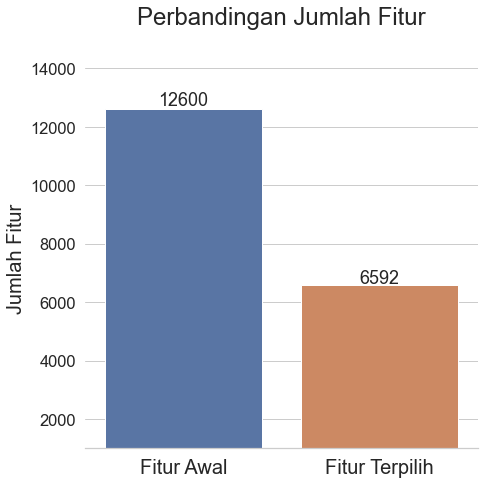

In [210]:
ax_y = [X.shape[1], np.count_nonzero(pop_pos[np.argmax(pop_acc)])]
ax_x = ['Fitur Awal', 'Fitur Terpilih']
plt.figure(figsize=(7,7))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
p = sns.barplot(x=ax_x, y=ax_y)
sns.despine(left=True)
p.set_title('Perbandingan Jumlah Fitur', fontsize=24, y=1.1)
p.set_ylabel("Jumlah Fitur", fontsize = 20)
p.set_xticklabels(ax_x, fontsize = 20)
p.set_ylim(1000, 14000)
sns.set(font_scale=1.3)
show_values(p, fmt='{:.0f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Jumlah Fitur.png')

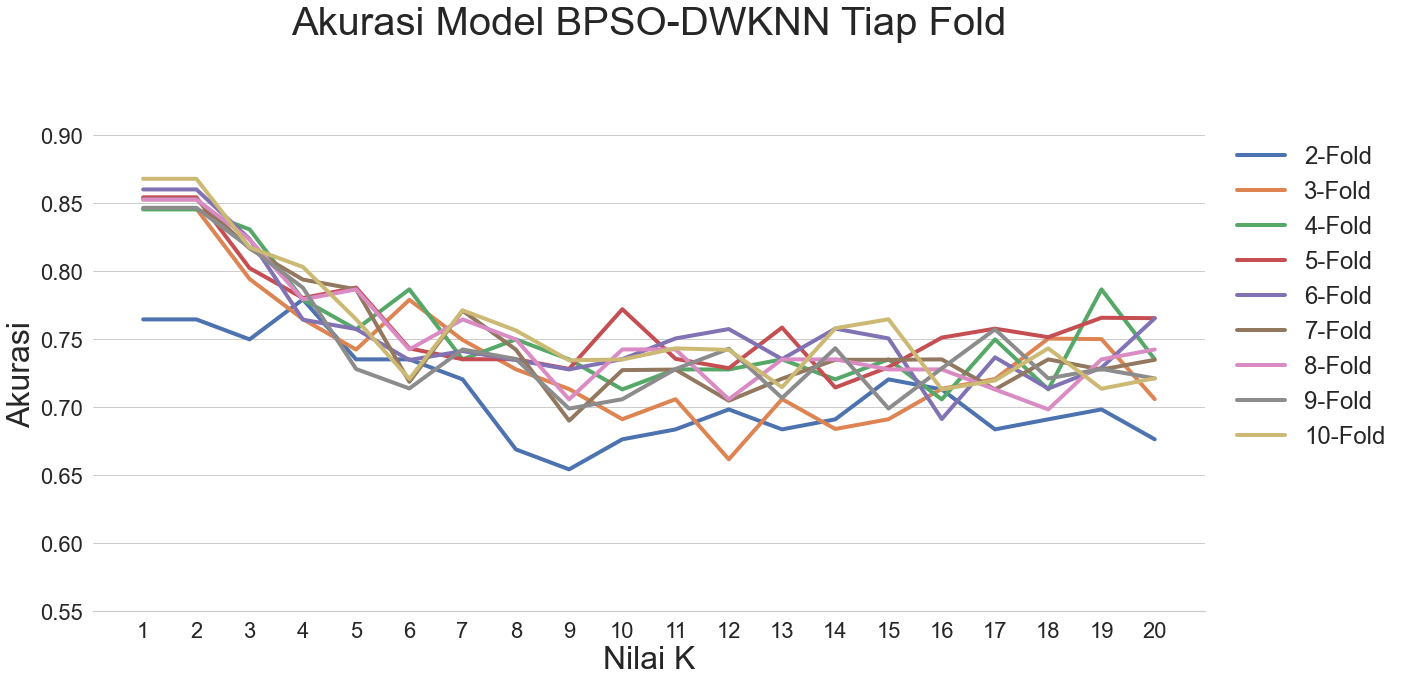

In [211]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_acc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Akurasi', fontsize=32)
p.set_yticks([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])
p.set_title('Akurasi Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Akurasi BPSO-DW Tiap Fold.png')

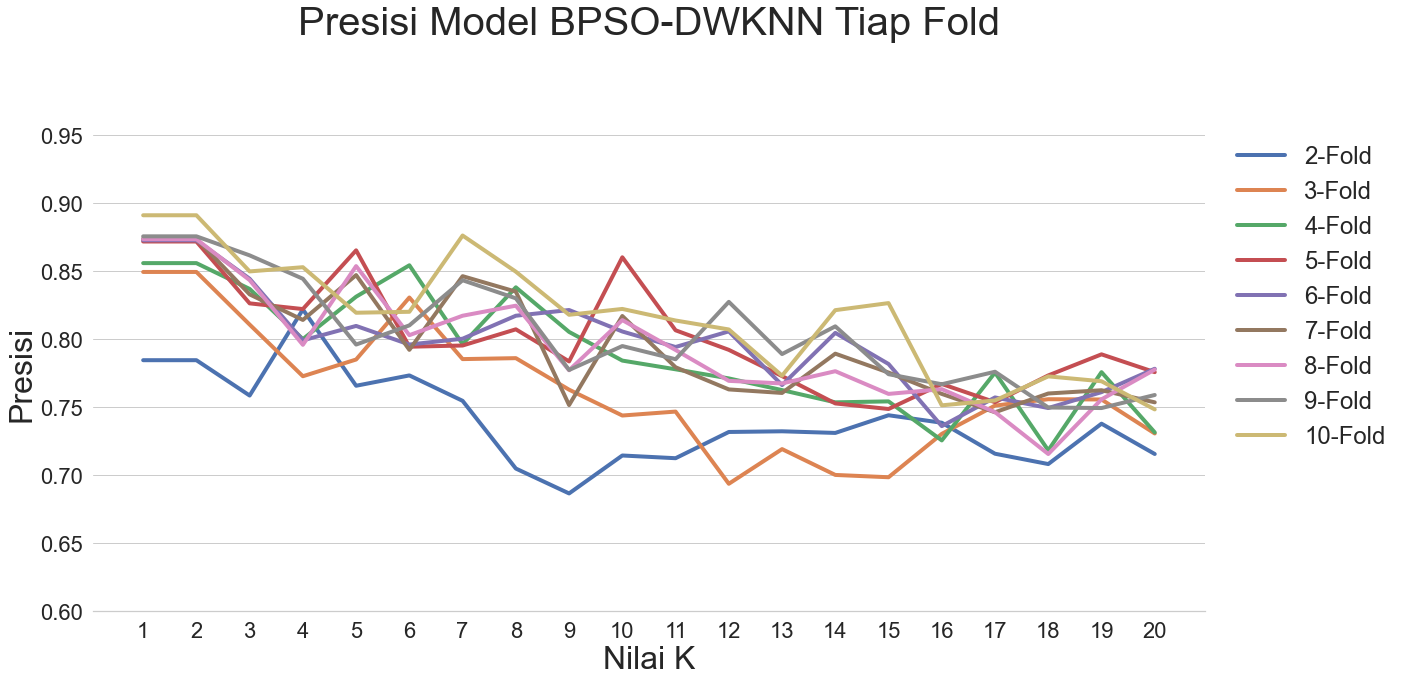

In [212]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_prc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Presisi', fontsize=32)
p.set_yticks([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
p.set_title('Presisi Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Presisi BPSO-DW Tiap Fold.png')

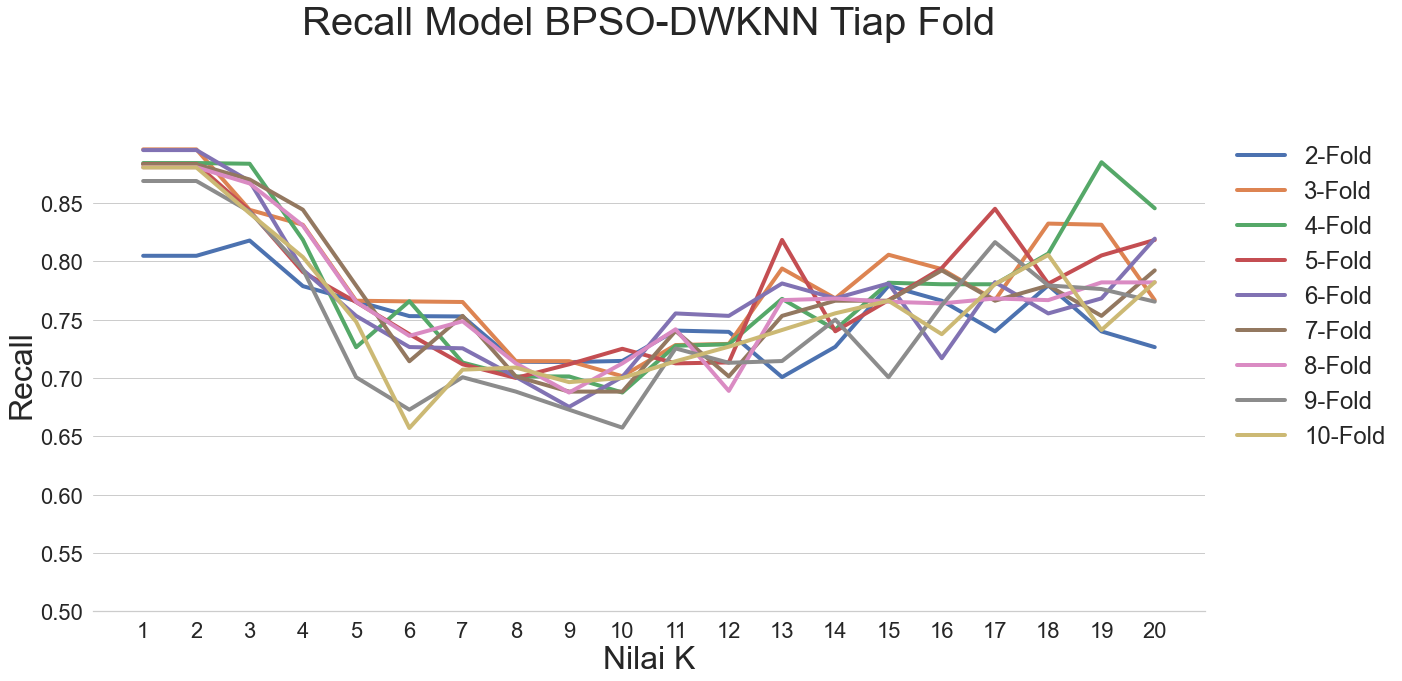

In [213]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_rcl[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Recall', fontsize=32)
p.set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
p.set_title('Recall Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Recall BPSO-DW Tiap Fold.png')

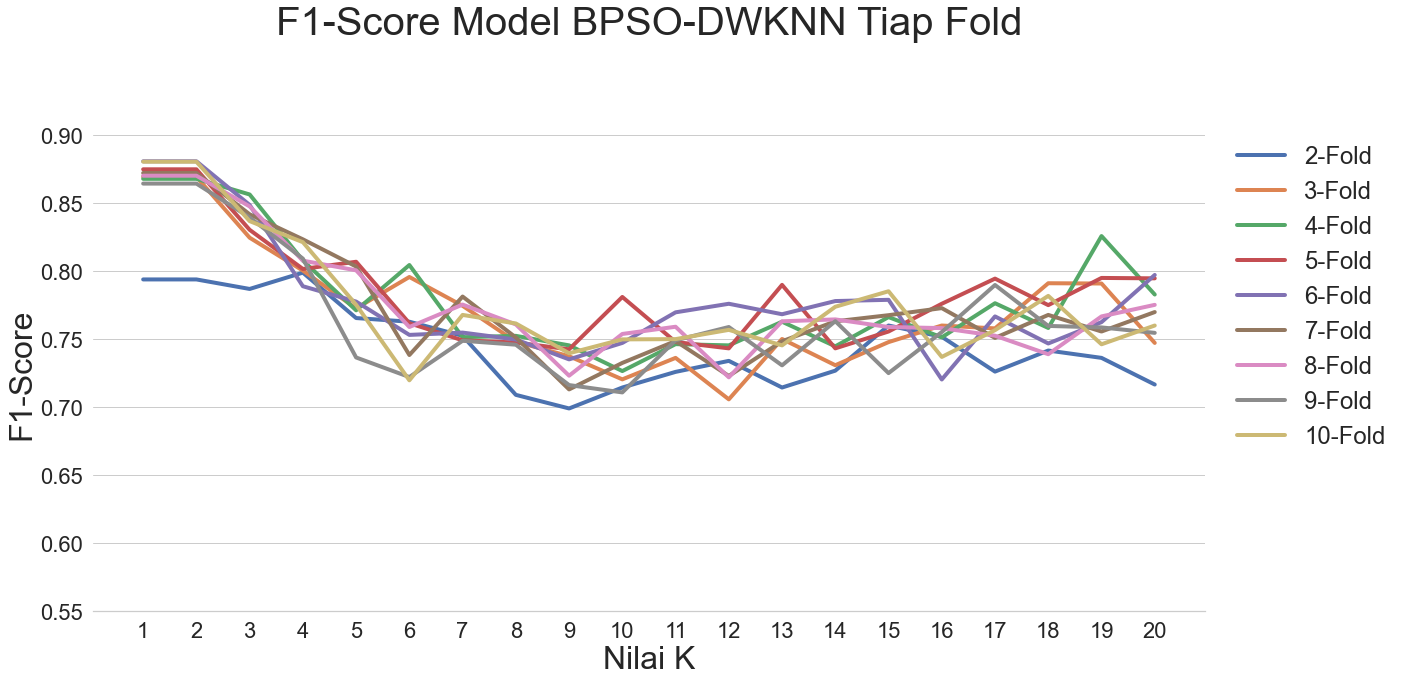

In [214]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_f1[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('F1-Score', fontsize=32)
p.set_yticks([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])
p.set_title('F1-Score Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/F1-Score BPSO-DW Tiap Fold.png')

Confusion matrix, without normalization


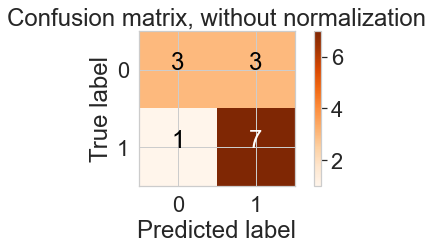

Confusion matrix, without normalization


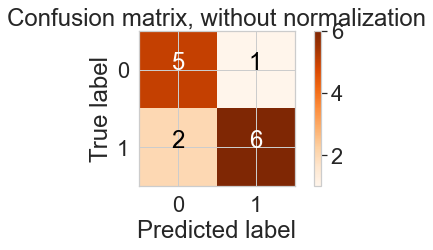

Confusion matrix, without normalization


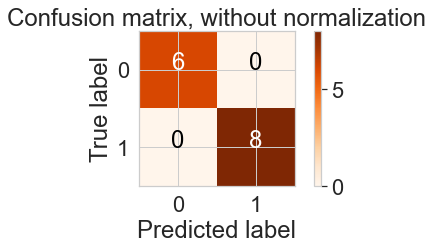

Confusion matrix, without normalization


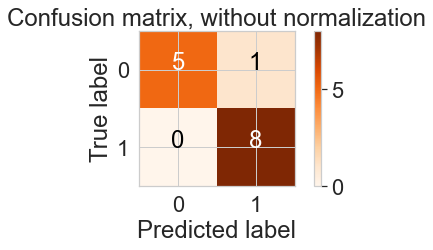

Confusion matrix, without normalization


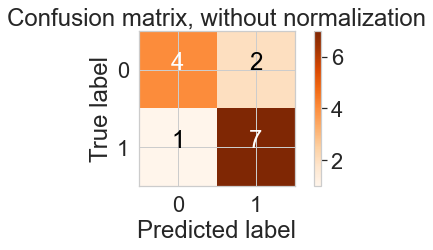

Confusion matrix, without normalization


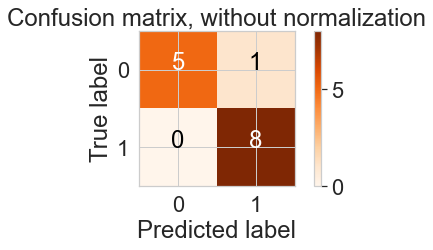

Confusion matrix, without normalization


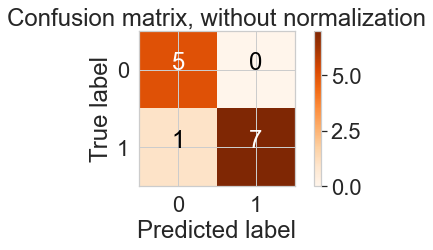

Confusion matrix, without normalization


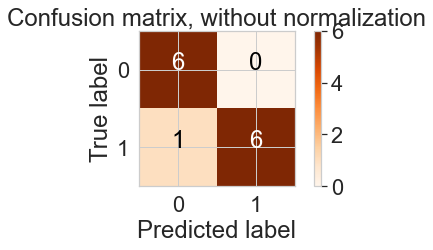

Confusion matrix, without normalization


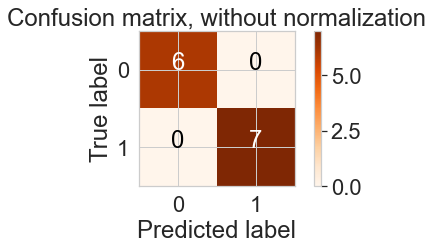

Confusion matrix, without normalization


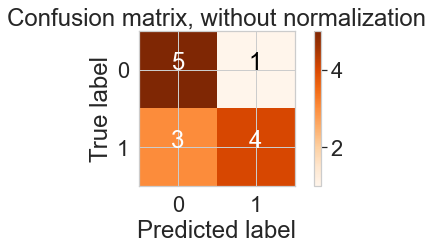

In [215]:
for i in range(10):
    plot_confusion_matrix(kfld_pred[8][1][i], kfld_act[8][1][i])

In [216]:
kfld_acc[8][1]

0.8681

## DWKNN Plot

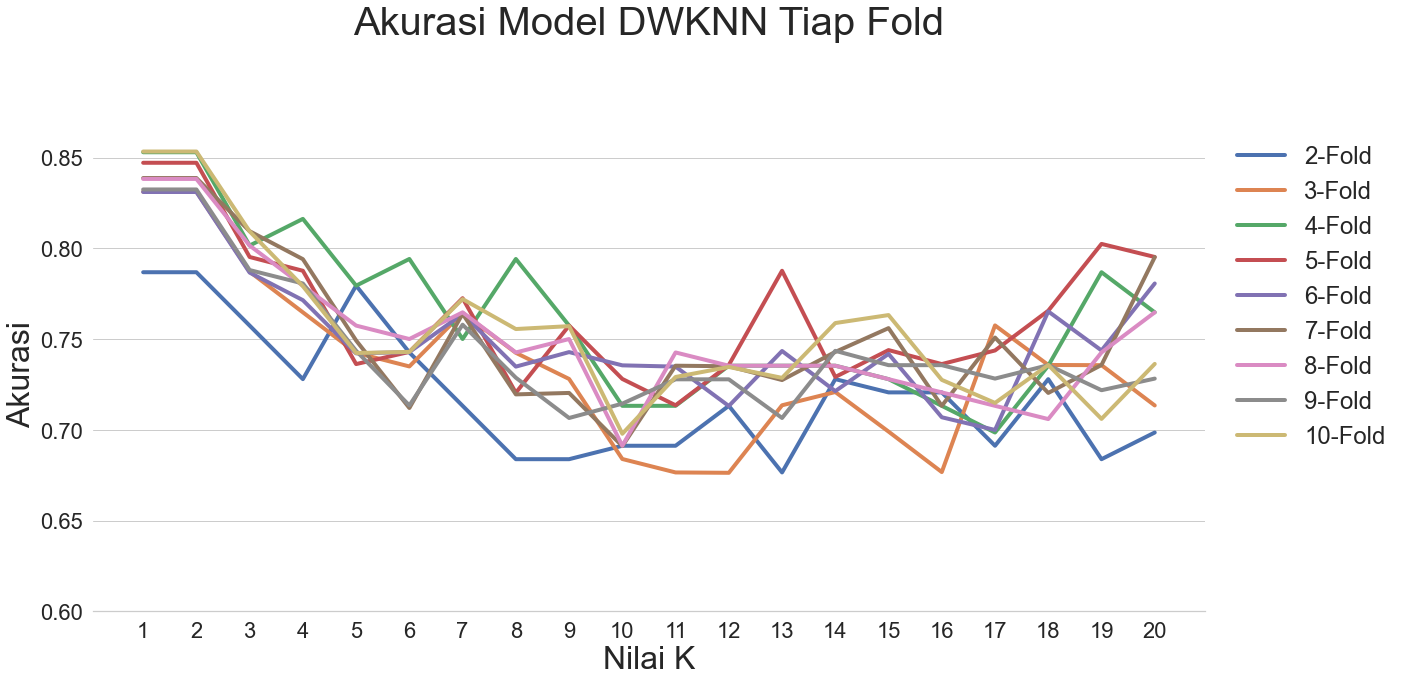

In [217]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_acc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Akurasi', fontsize=32)
p.set_yticks([0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
p.set_title('Akurasi Model DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Akurasi DW Tiap Fold.png')

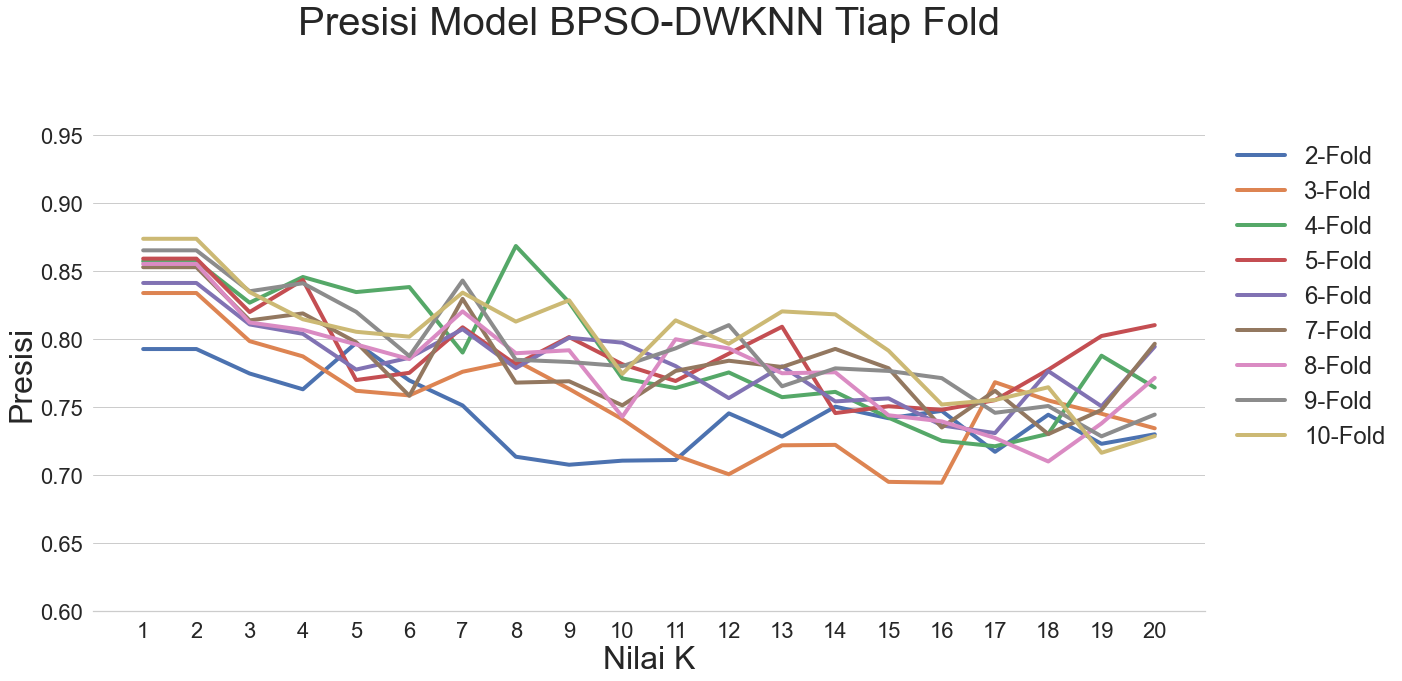

In [218]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_prc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Presisi', fontsize=32)
p.set_yticks([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
p.set_title('Presisi Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Presisi DW Tiap Fold.png')

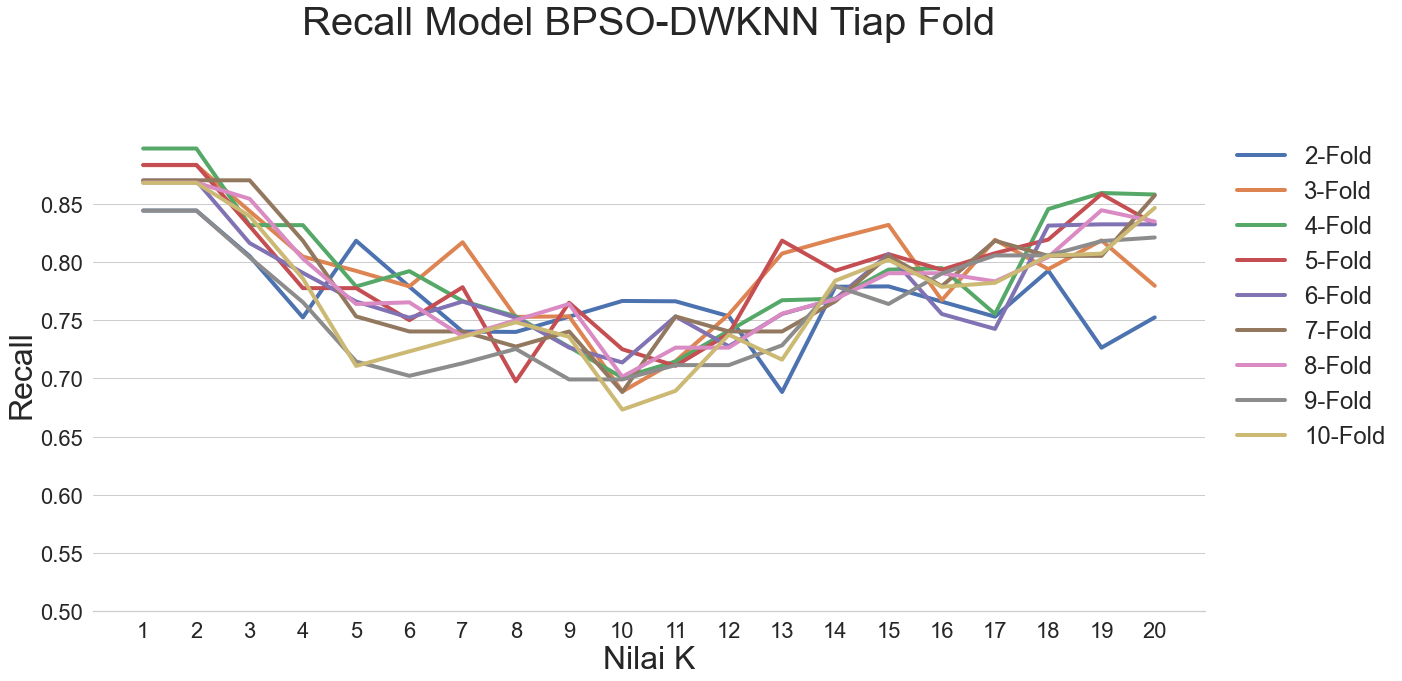

In [219]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_rcl[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Recall', fontsize=32)
p.set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
p.set_title('Recall Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Recall DW Tiap Fold.png')

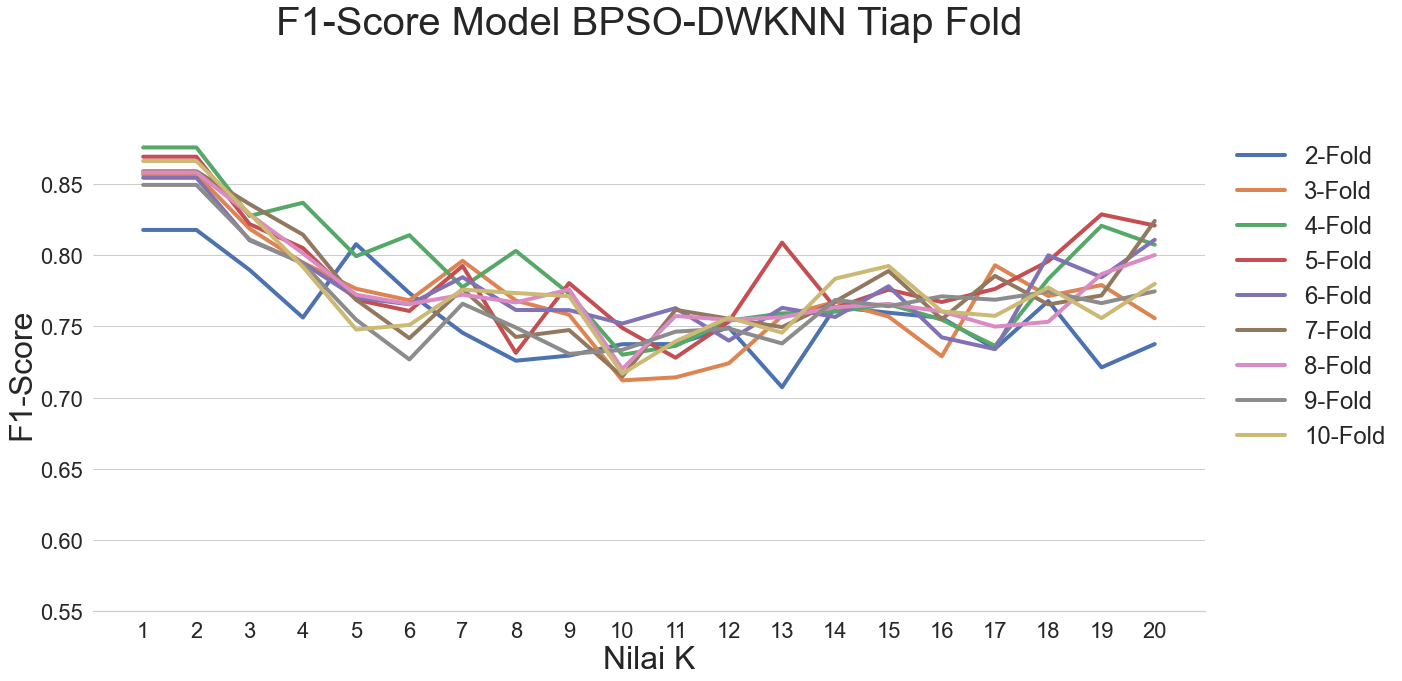

In [220]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_f1[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('F1-Score', fontsize=32)
p.set_yticks([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
p.set_title('F1-Score Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/F1-Score DW Tiap Fold.png')

Confusion matrix, without normalization


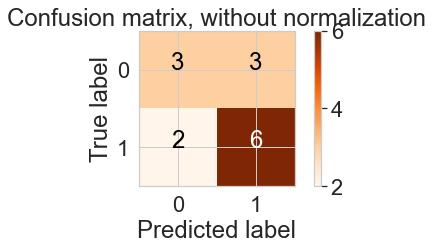

Confusion matrix, without normalization


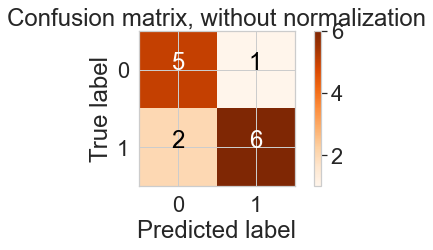

Confusion matrix, without normalization


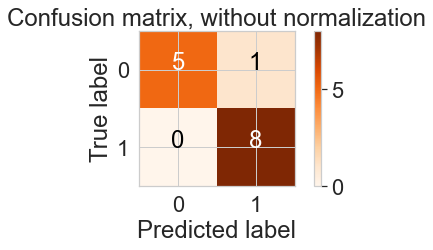

Confusion matrix, without normalization


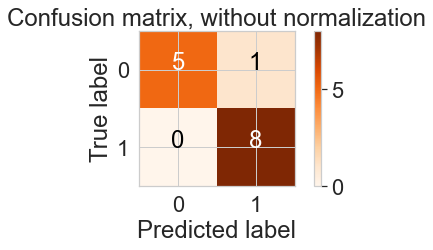

Confusion matrix, without normalization


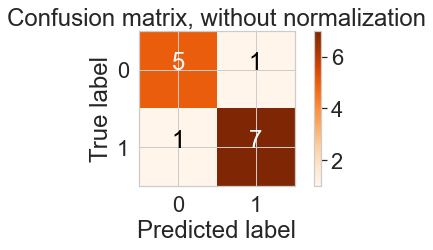

Confusion matrix, without normalization


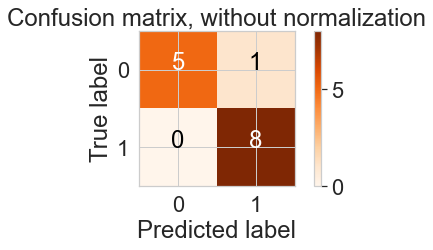

Confusion matrix, without normalization


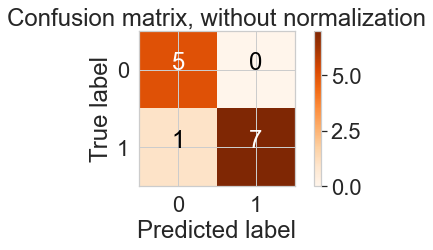

Confusion matrix, without normalization


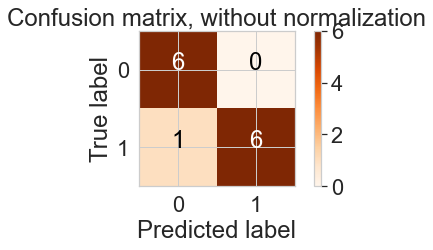

Confusion matrix, without normalization


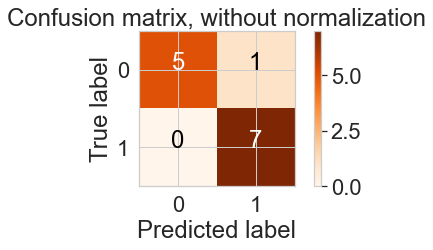

Confusion matrix, without normalization


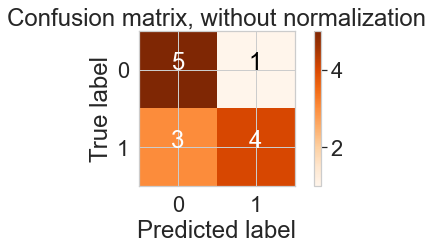

In [221]:
for i in range(10):
    plot_confusion_matrix(kfld_d_pred[8][1][i], kfld_d_act[8][1][i])

In [222]:
kfld_d_acc[8][1]

0.8533

## BPSO-DWKNN vs DWKNN

In [223]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
hsl01_df = pd.DataFrame({'Fold': fld,
              'Nilai K': val_k, 
              'Akurasi': max_akr,
              'Presisi': max_prc,
              'Recall': max_rcl,
              'F1-Score': max_f1,
              'Model': 'BPSO-DWKNN',
              })
hsl02_df = pd.DataFrame({'Fold': fld,
              'Nilai K': val_d_k, 
              'Akurasi': max_d_akr,
              'Presisi': max_d_prc,
              'Recall': max_d_rcl,
              'F1-Score': max_d_f1,
              'Model': 'DWKNN',
              })
hsl03_df = hsl01_df.append(hsl02_df)

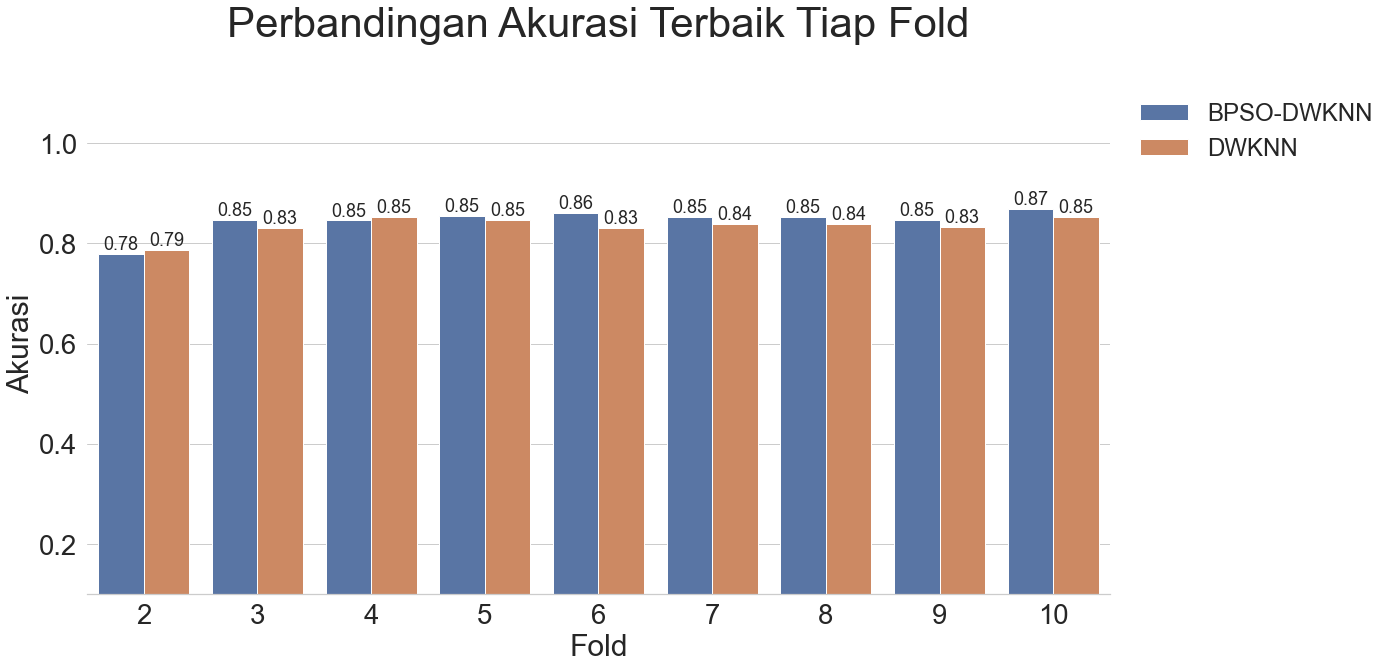

In [224]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Akurasi', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Perbandingan Akurasi Terbaik Tiap Fold.png')

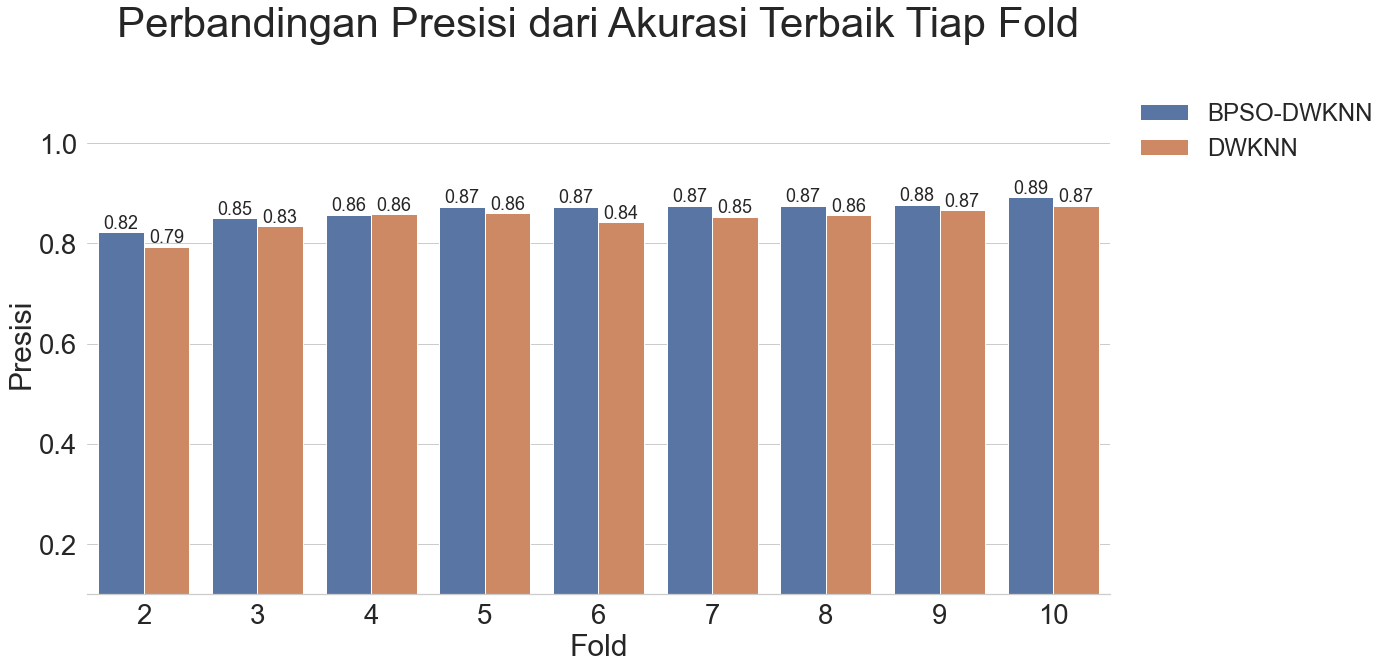

In [225]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Presisi', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Presisi dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Perbandingan Presisi dari Akurasi Terbaik Tiap Fold.png')

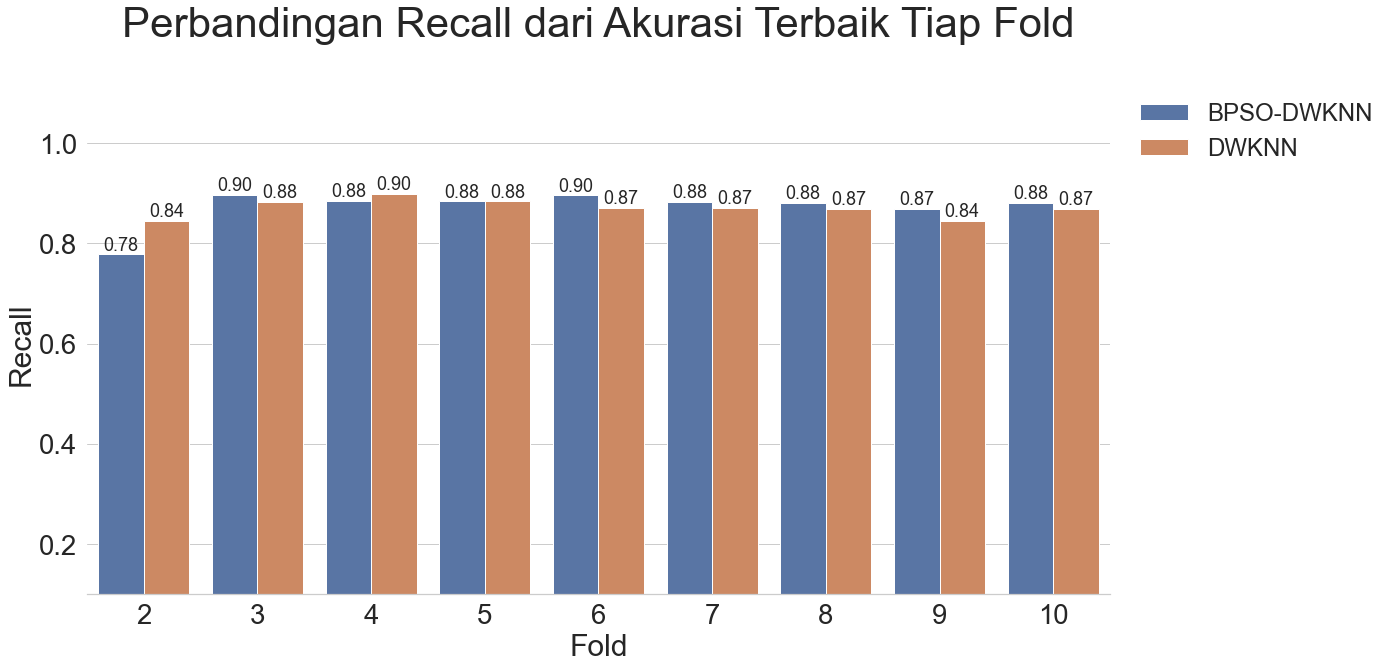

In [226]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Recall', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Recall dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Perbandingan Recall dari Akurasi Terbaik Tiap Fold.png')

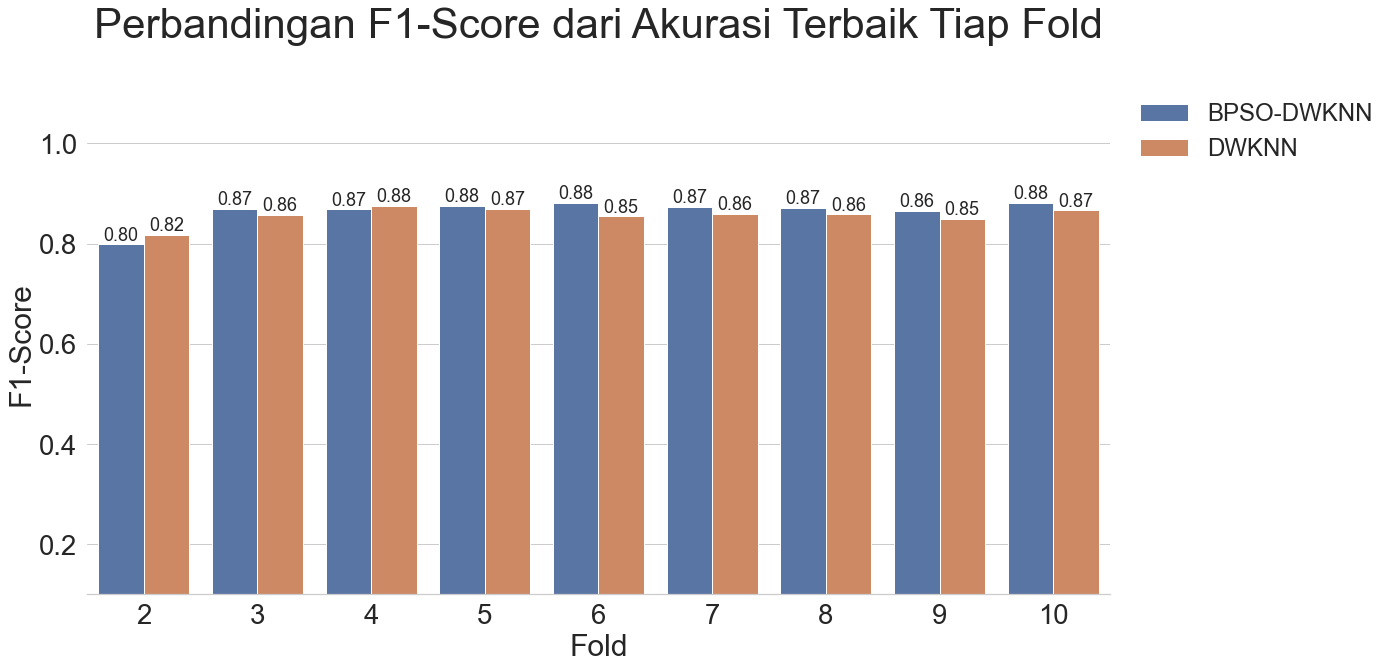

In [227]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='F1-Score', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan F1-Score dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/Perbandingan F1-Score dari Akurasi Terbaik Tiap Fold.png')

In [228]:
max_all_df = pd.DataFrame({'Matriks':['Akurasi', 'Presisi', 'Recall', 'F1-Score', 'Akurasi', 'Presisi', 'Recall', 'F1-Score'],
                        'Nilai':[np.max(bpdw_df.AkurasiTest.values), 
                                 bpdw_df.Presisi[np.argmax(bpdw_df.AkurasiTest.values)],                        
                                 bpdw_df.Recall[np.argmax(bpdw_df.AkurasiTest.values)], 
                                 bpdw_df.F1_Score[np.argmax(bpdw_df.AkurasiTest.values)], 
                                 np.max(dw_df.AkurasiTest.values), 
                                 dw_df.Presisi[np.argmax(dw_df.AkurasiTest.values)], 
                                 dw_df.Recall[np.argmax(dw_df.AkurasiTest.values)],
                                 dw_df.F1_Score[np.argmax(dw_df.AkurasiTest.values)]],
                        'Model':['BPSO-DWKNN', 'BPSO-DWKNN', 'BPSO-DWKNN', 'BPSO-DWKNN', 'DWKNN', 'DWKNN', 'DWKNN', 'DWKNN'],
                      })

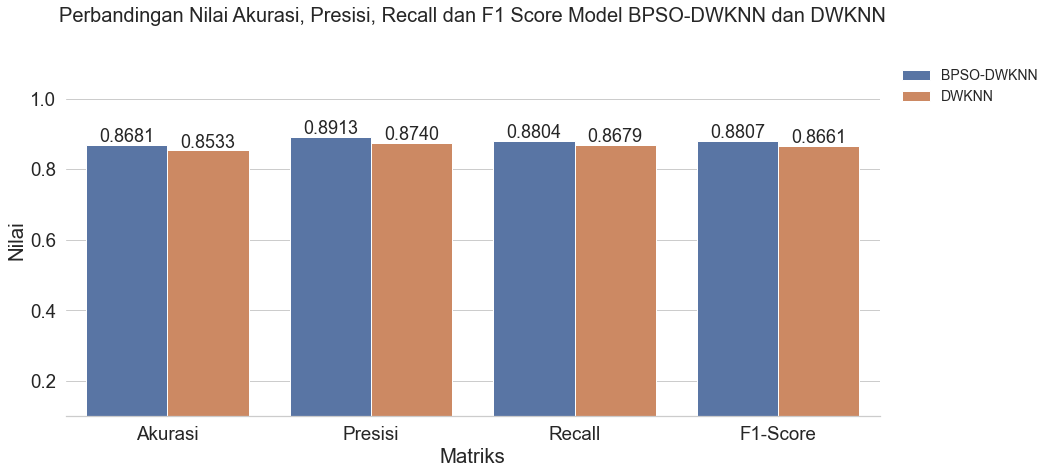

In [229]:
plt.figure(figsize=(15, 7))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=1.7)
sns.set_style('whitegrid')
p = sns.barplot(x='Matriks', y='Nilai', hue='Model', data=max_all_df)
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=14, frameon=False)
p.set_title('Perbandingan Nilai Akurasi, Presisi, Recall dan F1 Score Model BPSO-DWKNN dan DWKNN', fontsize=20, y=1.1)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/ConfusionMatrix BPSO-DW Vs DW.png')

## DataFrame to Excel

In [230]:
result_df = pd.DataFrame({'Model': ['BPSO-DWKNN', 'DWKNN'],
                      'Fold': [bpdw_df.Fold[np.argmax(bpdw_df.AkurasiTest)], dw_df.Fold[np.argmax(dw_df.AkurasiTest)]],
                      'Nilai K': [bpdw_df.Nilai_K[np.argmax(bpdw_df.AkurasiTest)], dw_df.Nilai_K[np.argmax(dw_df.AkurasiTest)]],
                      'Akurasi Train': [np.max(bpdw_df.AkurasiTrain.values), np.max(dw_df.AkurasiTrain.values)],
                      'Akurasi Test': [np.max(bpdw_df.AkurasiTest.values), np.max(dw_df.AkurasiTest.values)],
                      'Presisi': [bpdw_df.Presisi[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.Presisi[np.argmax(dw_df.AkurasiTest.values)]],
                      'Recall': [bpdw_df.Recall[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.Recall[np.argmax(dw_df.AkurasiTest.values)]],
                      'F1-Score': [bpdw_df.F1_Score[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.F1_Score[np.argmax(dw_df.AkurasiTest.values)]],
                      'Jumlah Fitur': [np.count_nonzero(pop_pos[np.argmax(pop_acc)]), X.shape[1]],
                      })

C:\Anaconda\envs\jcopml\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


In [231]:
result_df

Model  Fold  Nilai K  Akurasi Train  Akurasi Test  Presisi  Recall  \
0  BPSO-DWKNN    10        1            1.0        0.8681   0.8913  0.8804   
1       DWKNN    10        1            1.0        0.8533   0.8740  0.8679   

   F1-Score  Jumlah Fitur  
0    0.8807          6592  
1    0.8661         12600

In [243]:
fold_fs_df.name = "Percobaan Fold Pada Seleksi Fitur"
w0_df.name = "W = 0.9"
w1_df.name = "W = 0.1"
pop_df.name = "Percobaan Populasi"
result_df.name = "Hasil Akurasi"
bpdw_df.name = "Akurasi Terbaik BPSO-DWKNN tiap Fold"
dw_df.name = "Akurasi Terbaik DWKNN tiap Fold"

acc_bpdw_k_df.name = "Akurasi Per K Tiap Fold"
prc_bpdw_k_df.name = "Presisi Per K Tiap Fold"
rcl_bpdw_k_df.name = "Recall Per K Tiap Fold"
f1_bpdw_k_df.name = "F1-Score Per K Tiap Fold"

acc_d_bpdw_k_df.name = "Akurasi Per K Tiap Fold"
prc_d_bpdw_k_df.name = "Presisi Per K Tiap Fold"
rcl_d_bpdw_k_df.name = "Recall Per K Tiap Fold"
f1_d_bpdw_k_df.name = "F1-Score Per K Tiap Fold"

writer = pd.ExcelWriter('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate.xlsx',engine='xlsxwriter')
workbook=writer.book

# Formating
merge_format = workbook.add_format({
    'bold': 1,
    'border': None,
    'align': 'center',
    'valign': 'vcenter',
    'fg_color': '#fc8f30',
    'font_color': 'white'})

cell_format = workbook.add_format({
    'bg_color': '#ffdea1'})

border_fmt = workbook.add_format({
    'bottom':3, 
    'top':3, 
    'left':3, 
    'right':3})


# Excel Fold
worksheet=workbook.add_worksheet('Fold')
writer.sheets['Fold'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(fold_fs_df)+1, len(fold_fs_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:G1', fold_fs_df.name, merge_format)
# to_xlsx
fold_fs_df.to_excel(writer,sheet_name='Fold',startrow=1 , startcol=0, index=None)

#Excel Parameter PSO
worksheet=workbook.add_worksheet('BPSOPar')
writer.sheets['BPSOPar'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(w0_df)+1, len(w0_df.columns)), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 5), {'type': 'no_errors', 'format': cell_format})
worksheet.conditional_format(xlsxwriter.utility.xl_range(2, 0, 6, 0), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:F1', w0_df.name, merge_format)
# to_xlsx
w0_df.to_excel(writer,sheet_name='BPSOPar',startrow=1 , startcol=0)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(10, 0, 15, 5), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(10, 0, 10, 5), {'type': 'no_errors', 'format': cell_format})
worksheet.conditional_format(xlsxwriter.utility.xl_range(11, 0, 15, 0), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A10:F10', w1_df.name, merge_format)
# to_xlsx
w1_df.to_excel(writer,sheet_name='BPSOPar',startrow=w0_df.shape[0] + 5, startcol=0)
# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(19, 0, 23, 6), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(19, 0, 19, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A19:G19', pop_df.name, merge_format)
# to_xlsx
pop_df.to_excel(writer,sheet_name='BPSOPar',startrow=w0_df.shape[0] + w1_df.shape[0] + 9, startcol=0, index=None)

# Excel Tabel Akurasi Terbaik BPSO-DW Tiap Fold
worksheet=workbook.add_worksheet('BPSO-DWKNN')
writer.sheets['BPSO-DWKNN'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(bpdw_df)+1, len(bpdw_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 7), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:H1', bpdw_df.name, merge_format)
# to_xlsx
bpdw_df.to_excel(writer,sheet_name='BPSO-DWKNN',startrow=1 , startcol=0, index=None)

# Excel Tabel Akurasi Terbaik DW Tiap Fold
worksheet=workbook.add_worksheet('DWKNN')
writer.sheets['DWKNN'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(dw_df)+1, len(dw_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:G1', dw_df.name, merge_format)
# to_xlsx
dw_df.to_excel(writer,sheet_name='DWKNN',startrow=1 , startcol=0, index=None)

#Excel Hasil Akhir
worksheet=workbook.add_worksheet('Hasil Akurasi')
writer.sheets['Hasil Akurasi'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(result_df)+1, len(result_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 8), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:I1', result_df.name, merge_format)
# to xlsx
result_df.to_excel(writer,sheet_name='Hasil Akurasi',startrow=1 , startcol=0, index=None)

#Excel Acc, prc, rcl, f1 BPSO DW perFold
worksheet=workbook.add_worksheet('BPSO-DW Acc, Prc, Rcl, F1')
writer.sheets['BPSO-DW Acc, Prc, Rcl, F1'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(acc_bpdw_k_df)+1, len(acc_bpdw_k_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:J1', acc_bpdw_k_df.name, merge_format)
# to xlsx
acc_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1',startrow=1 , startcol=0, index=None)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 45, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 25, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A25:J25', prc_bpdw_k_df.name, merge_format)
# to_xlsx
prc_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5, startcol=0, index=None)

# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 69, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 49, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A49:J49', rcl_bpdw_k_df.name, merge_format)
# to_xlsx
rcl_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5 + prc_bpdw_k_df.shape[0] + 4, startcol=0, index=None)
# Styling Tabel 4
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 93, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 73, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A73:J73', f1_bpdw_k_df.name, merge_format)
# to_xlsx
f1_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5 + prc_bpdw_k_df.shape[0] + 5 + rcl_bpdw_k_df.shape[0] + 3, startcol=0, index=None)

#Excel Acc, prc, rcl, f1 DW perFold
worksheet=workbook.add_worksheet('DW Acc, Prc, Rcl, F1')
writer.sheets['DW Acc, Prc, Rcl, F1'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(acc_d_bpdw_k_df)+1, len(acc_d_bpdw_k_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:J1', acc_d_bpdw_k_df.name, merge_format)
# to xlsx
acc_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1',startrow=1 , startcol=0, index=None)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 45, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 25, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A25:J25', prc_d_bpdw_k_df.name, merge_format)
# to_xlsx
prc_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5, startcol=0, index=None)

# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 69, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 49, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A49:J49', rcl_d_bpdw_k_df.name, merge_format)
# to_xlsx
rcl_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5 + prc_d_bpdw_k_df.shape[0] + 4, startcol=0, index=None)
# Styling Tabel 4
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 93, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 73, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A73:J73', f1_d_bpdw_k_df.name, merge_format)
# to_xlsx
f1_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5 + prc_d_bpdw_k_df.shape[0] + 5 + rcl_d_bpdw_k_df.shape[0] + 3, startcol=0, index=None)

writer.save()

## Plot Per Fold

### BPSO-DWKNN

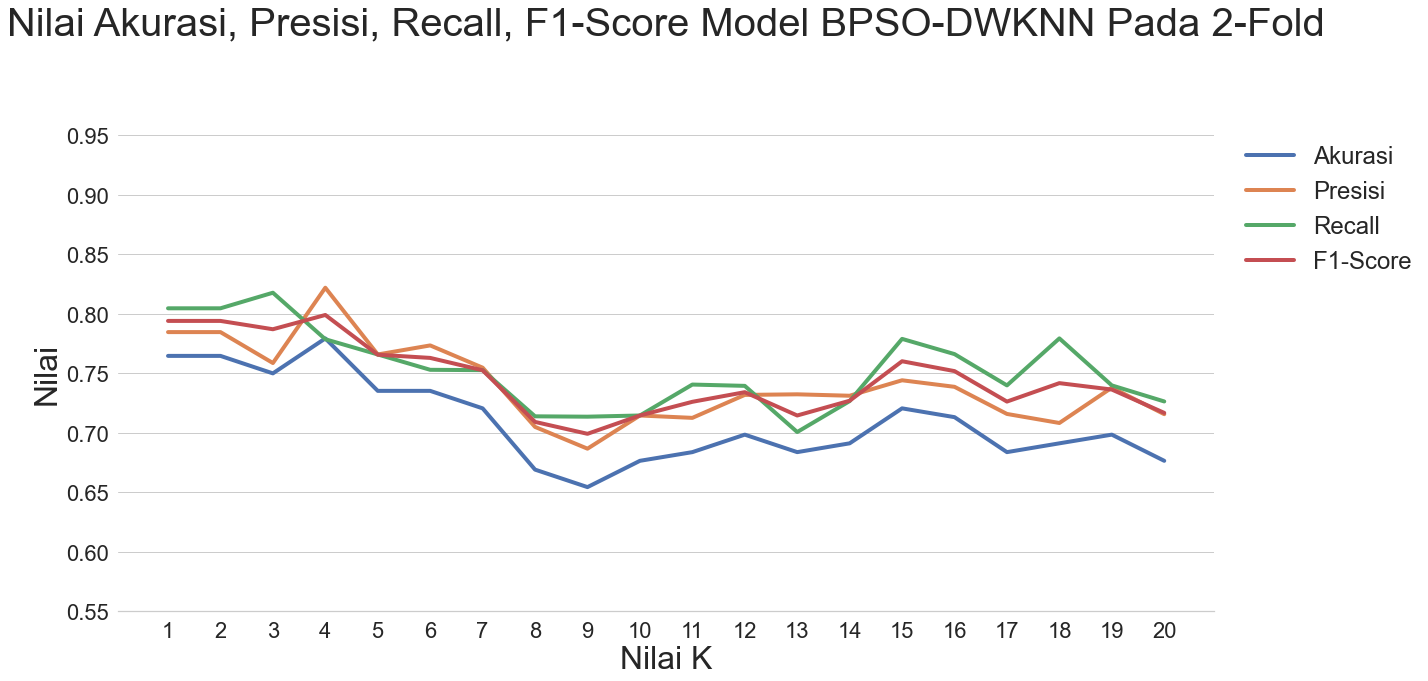

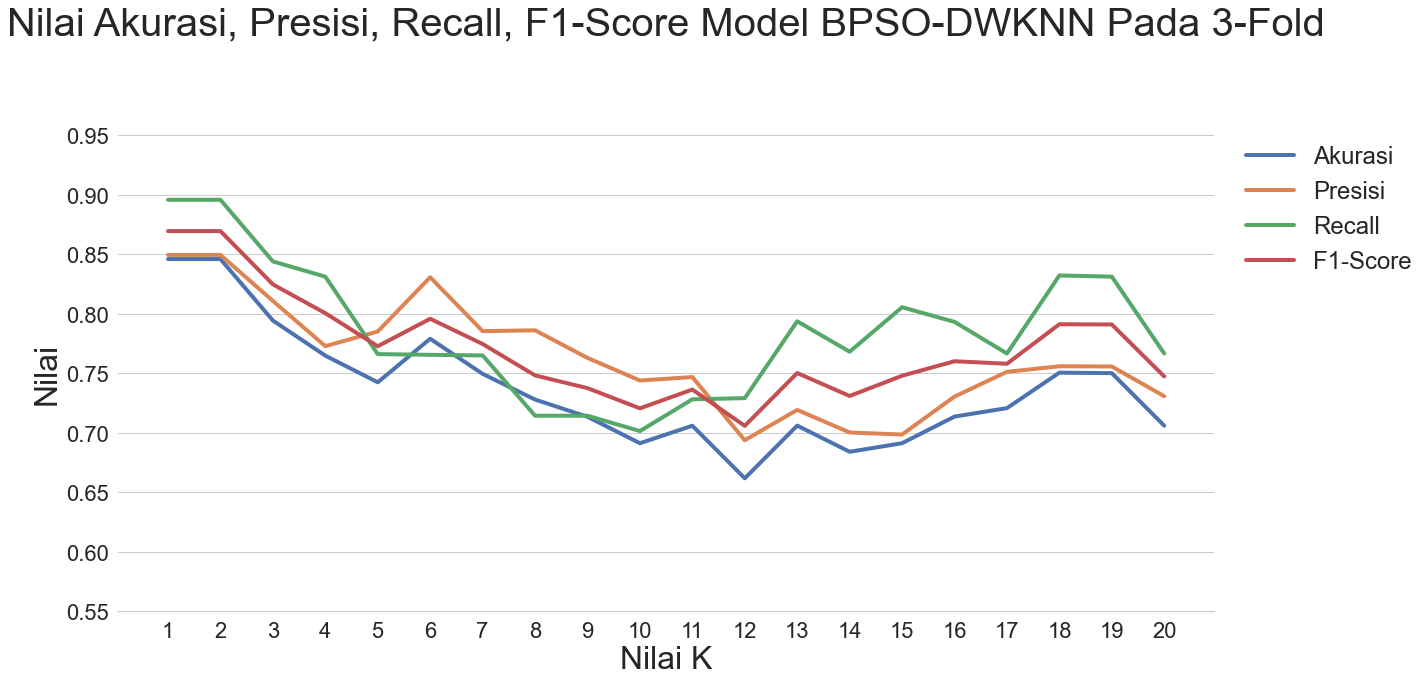

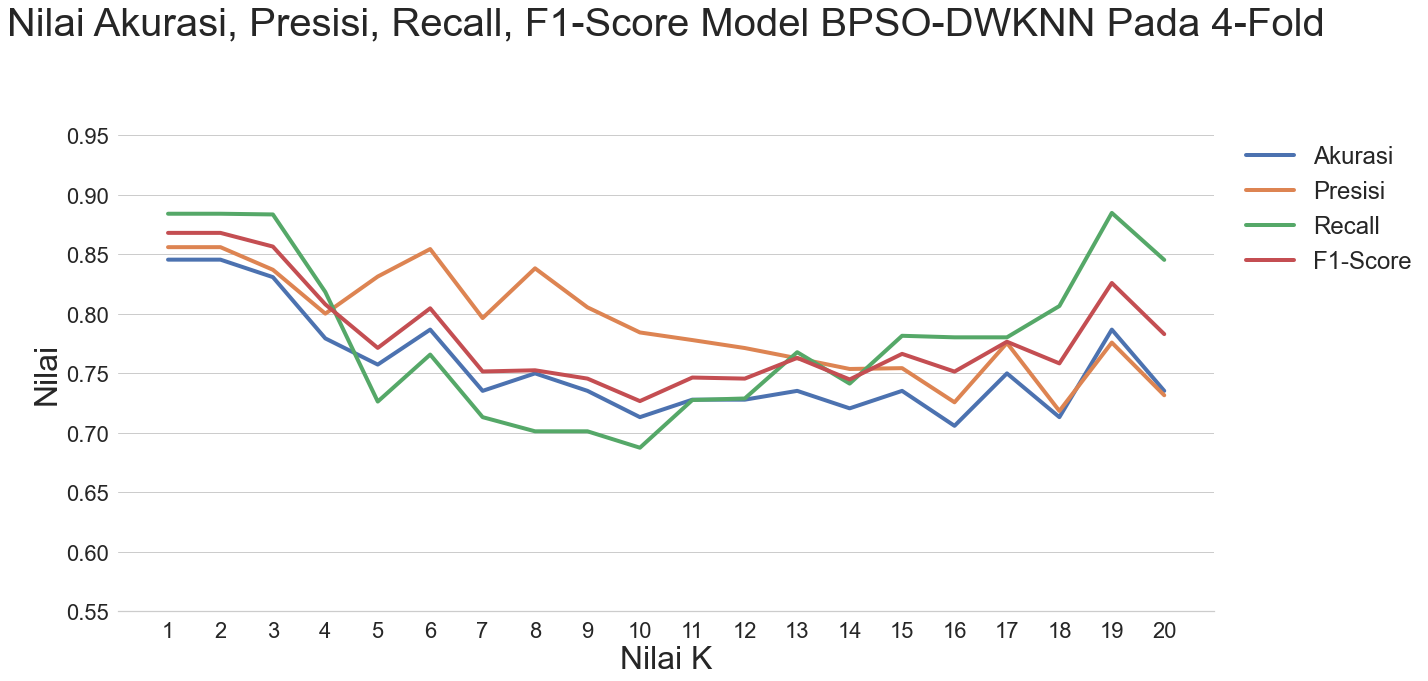

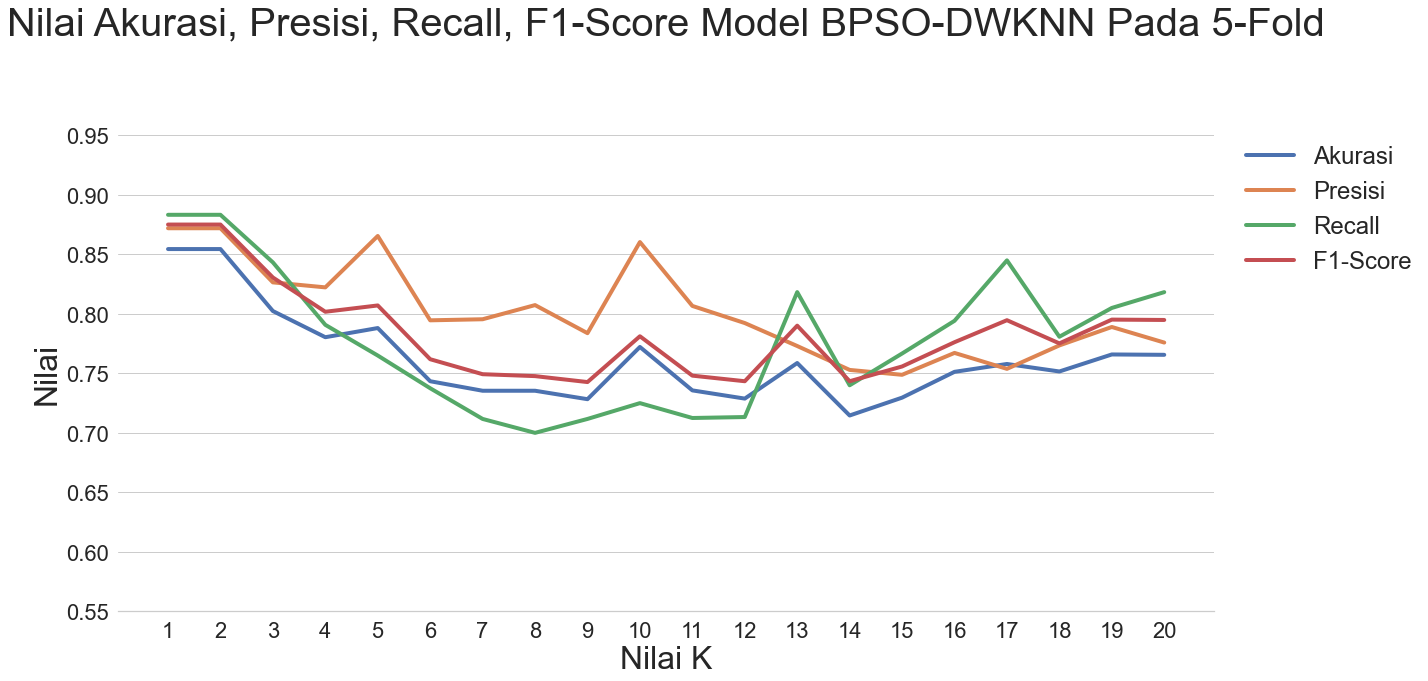

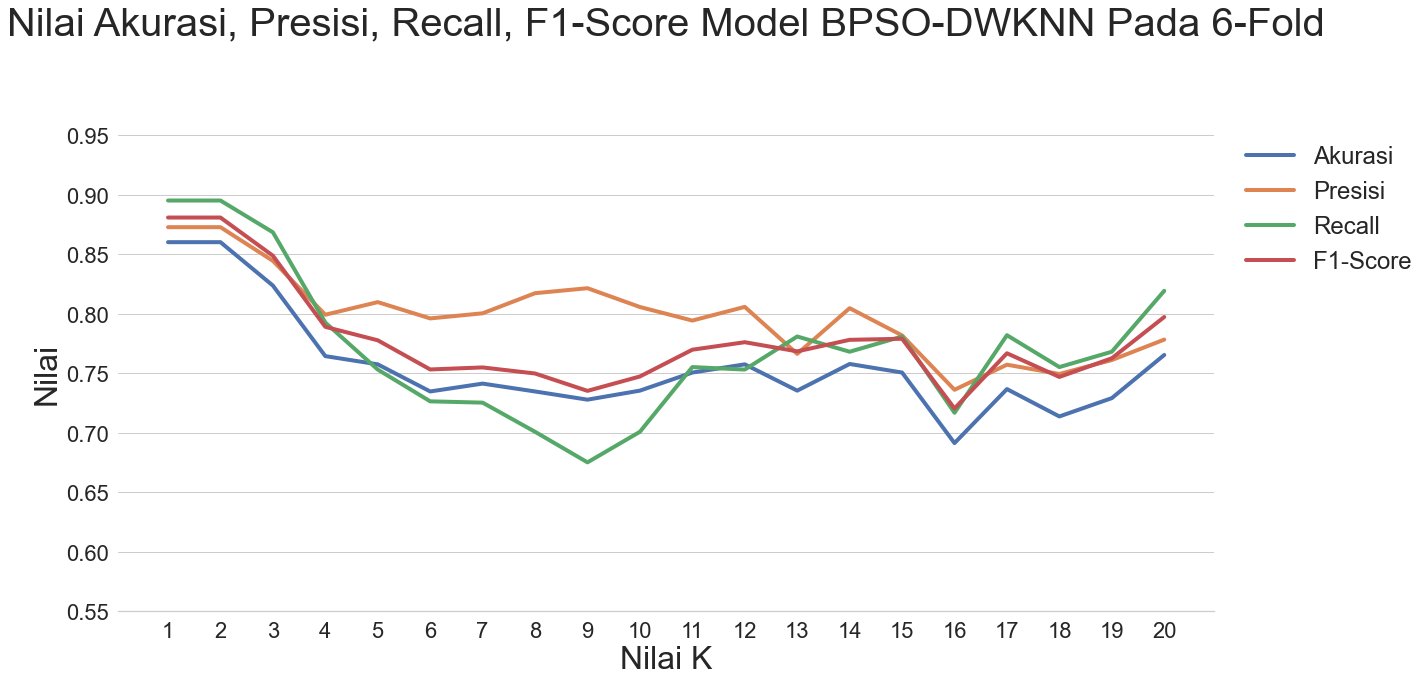

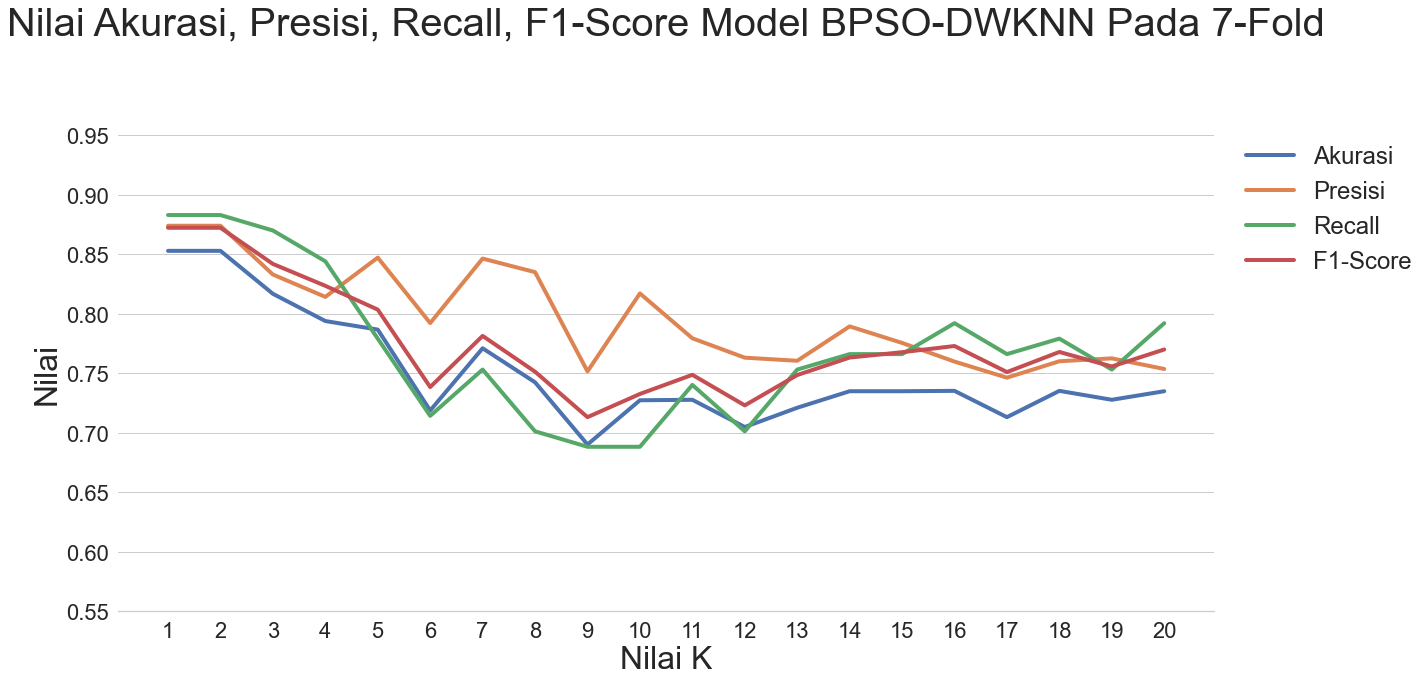

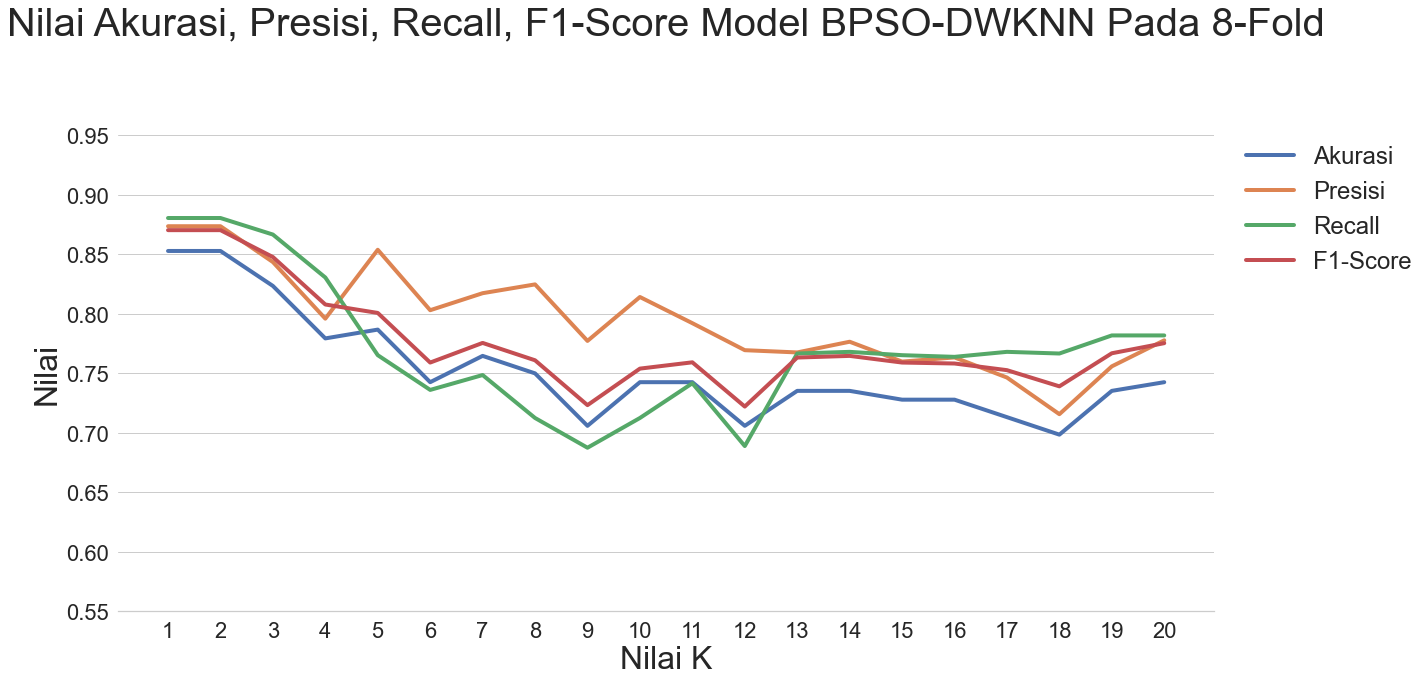

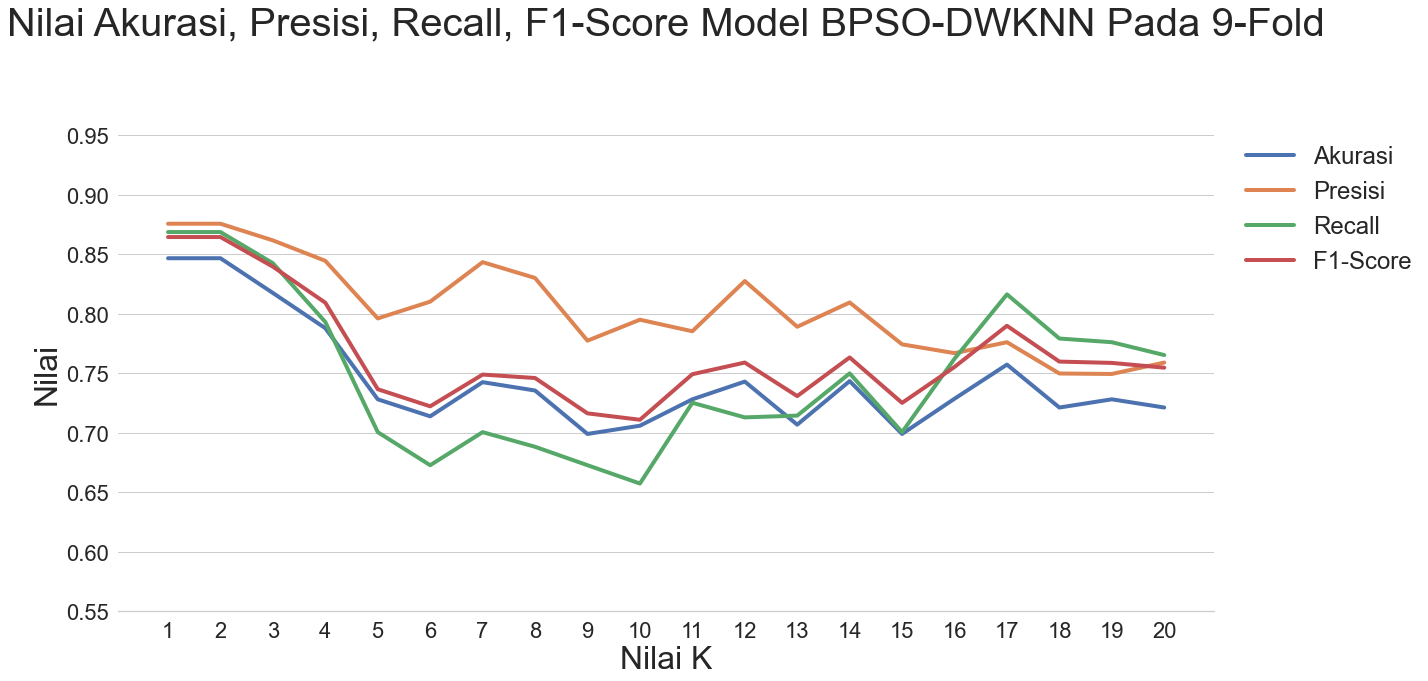

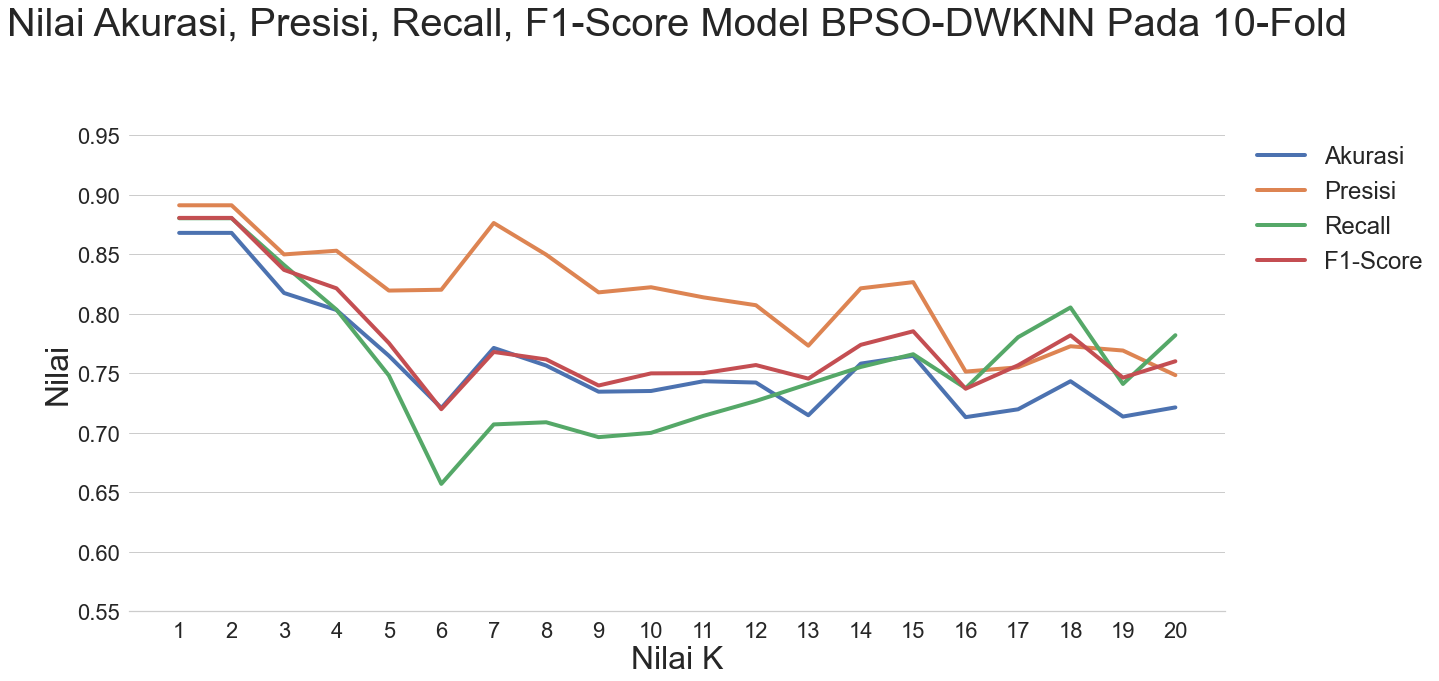

In [233]:
for i in range(9):
    plt.figure(figsize=(20,10))
    plt.rcParams['figure.autolayout'] = True
    sns.set(font_scale=2)
    sns.set_style('whitegrid')
    p = sns.lineplot(range_k0, kfld_acc[i], label='Akurasi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_prc[i], label='Presisi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_rcl[i], label='Recall', linewidth=4)
    p = sns.lineplot(range_k0, kfld_f1[i], label='F1-Score', linewidth=4)
    p.set_title('Nilai Akurasi, Presisi, Recall, F1-Score Model BPSO-DWKNN Pada {}-Fold'.format(i+2), fontsize=40, y=1.2)
    p.xaxis.grid(False)
    p.set_xlabel('Nilai K', fontsize=32)
    p.set_xticks(range(1,21))
    p.set_ylabel('Nilai', fontsize=32)
    p.set_yticks([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    sns.despine(left=True, bottom=False)
    p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
    p_fig = p.get_figure()
    p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/BPSO-DW Per Fold/BPSO-DW {}-Fold.png'.format(i+2))

### DWKNN

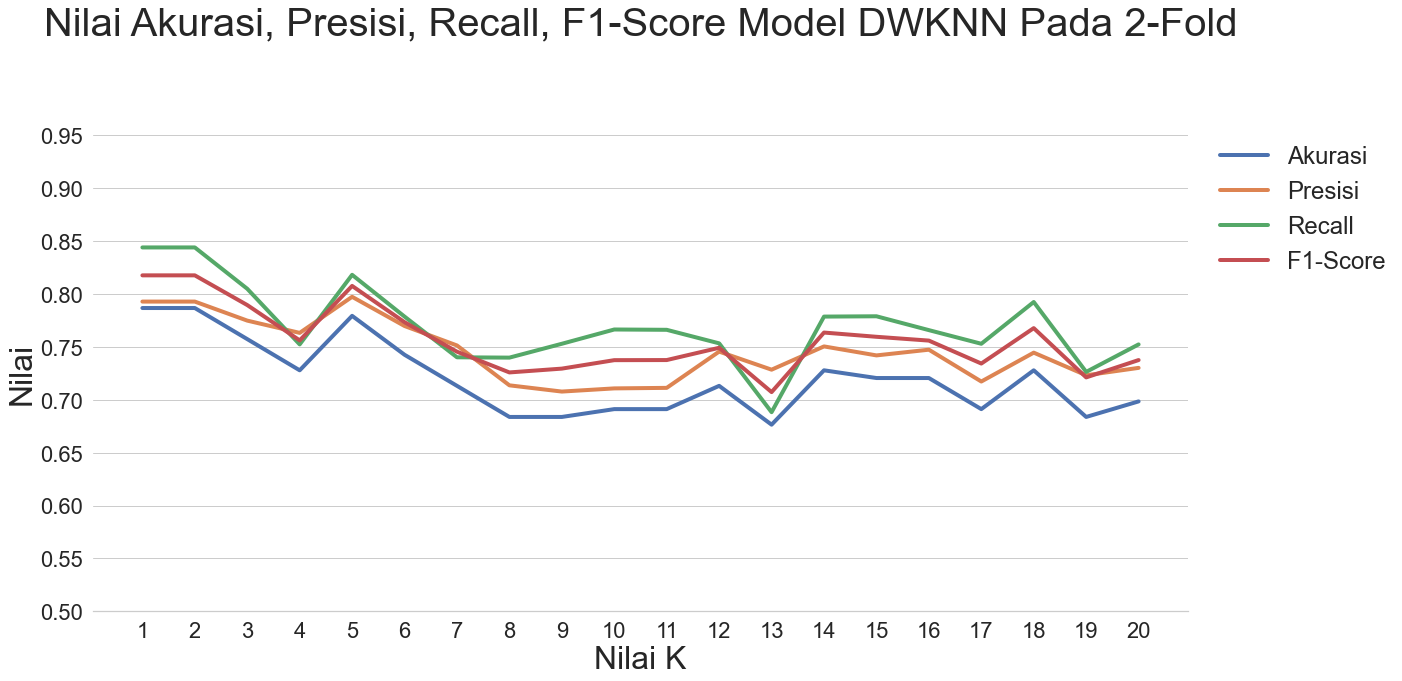

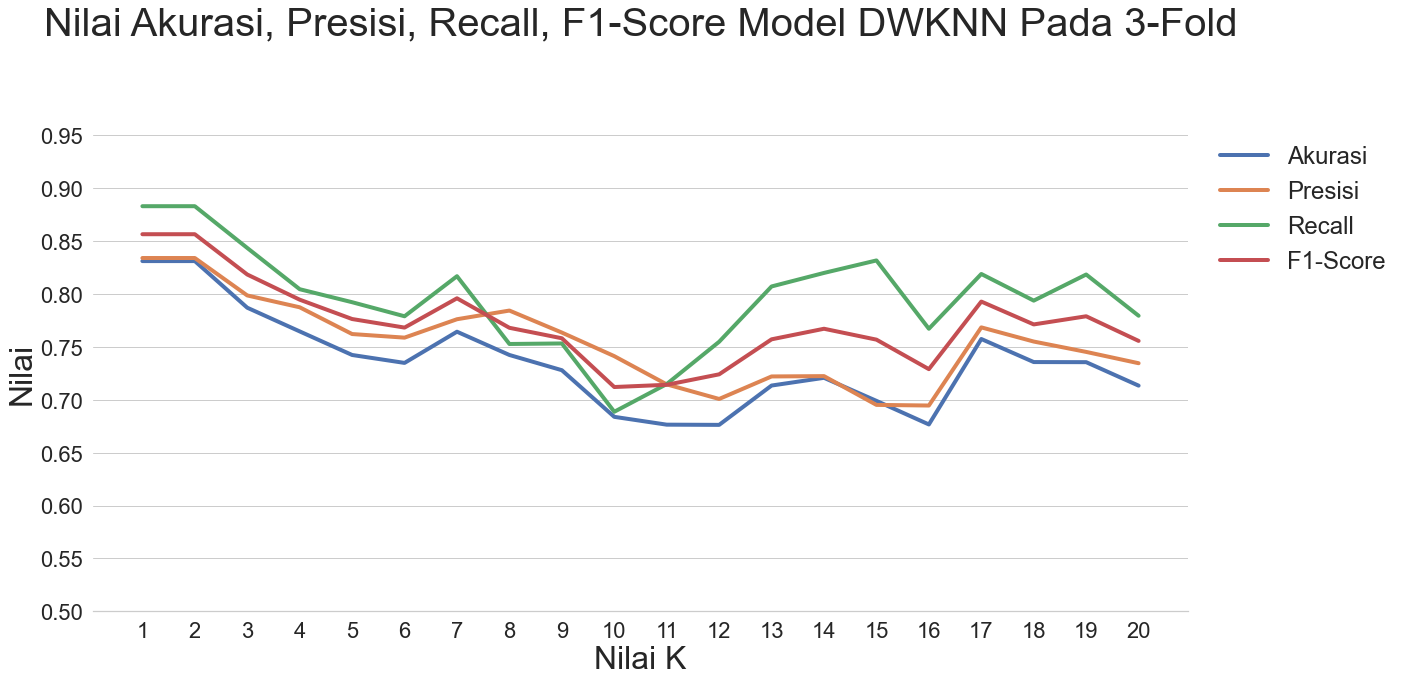

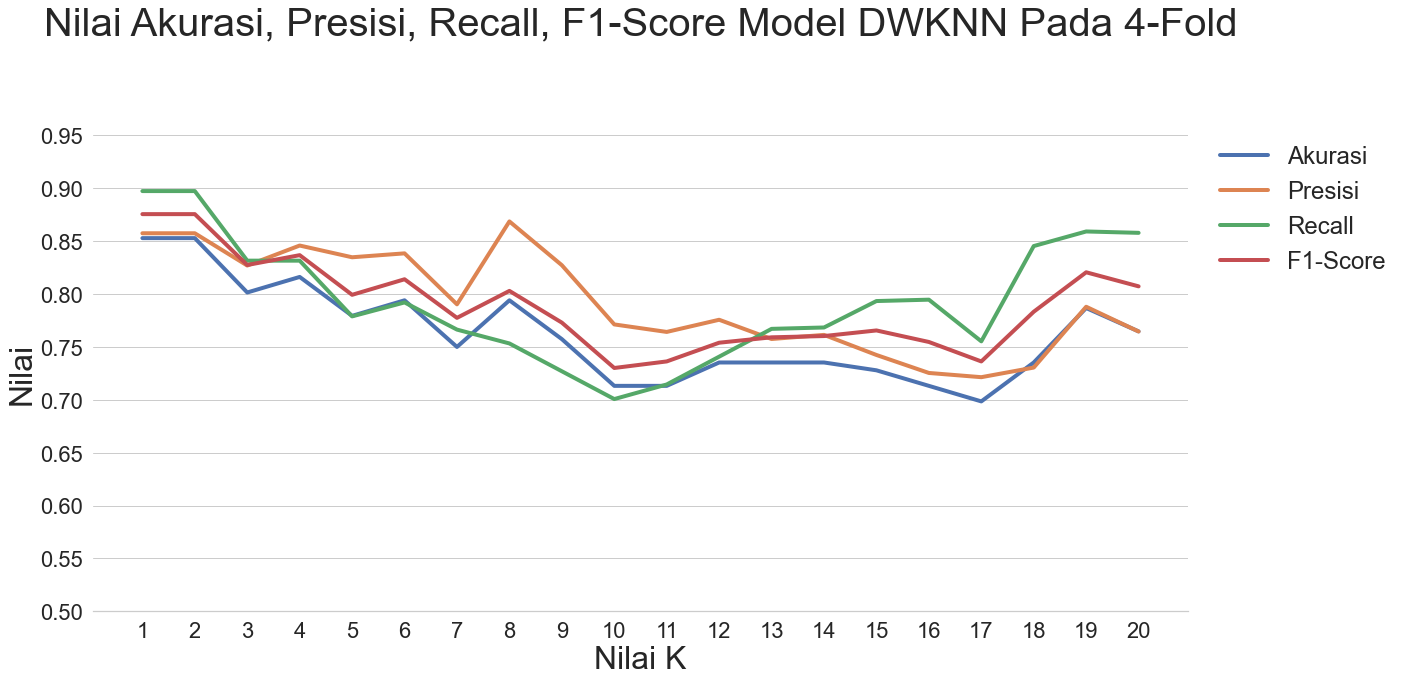

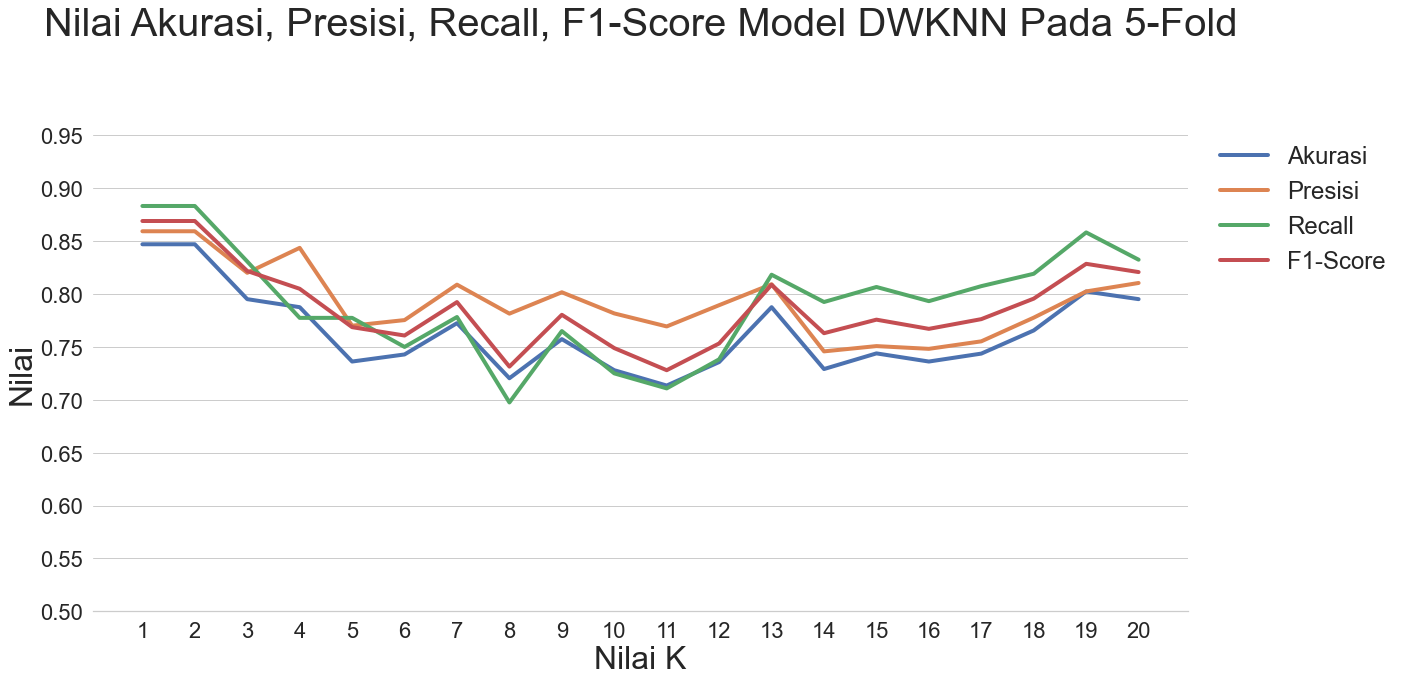

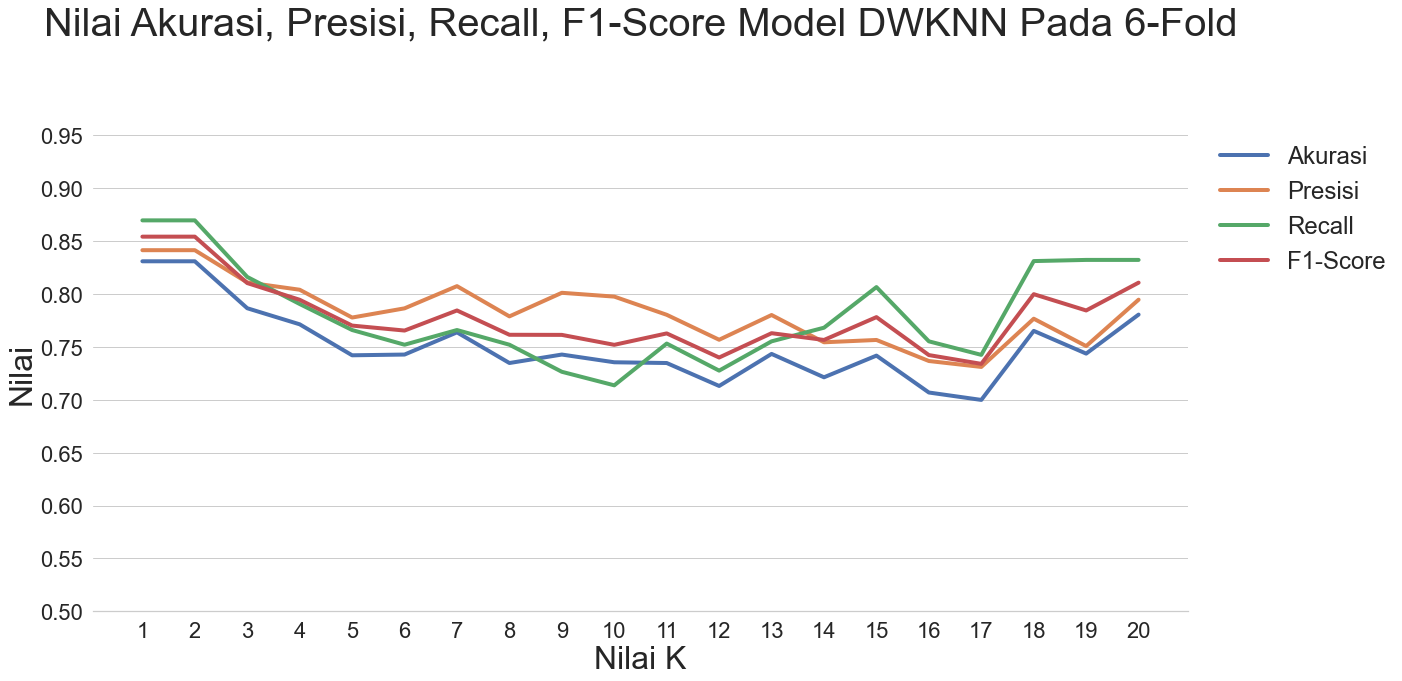

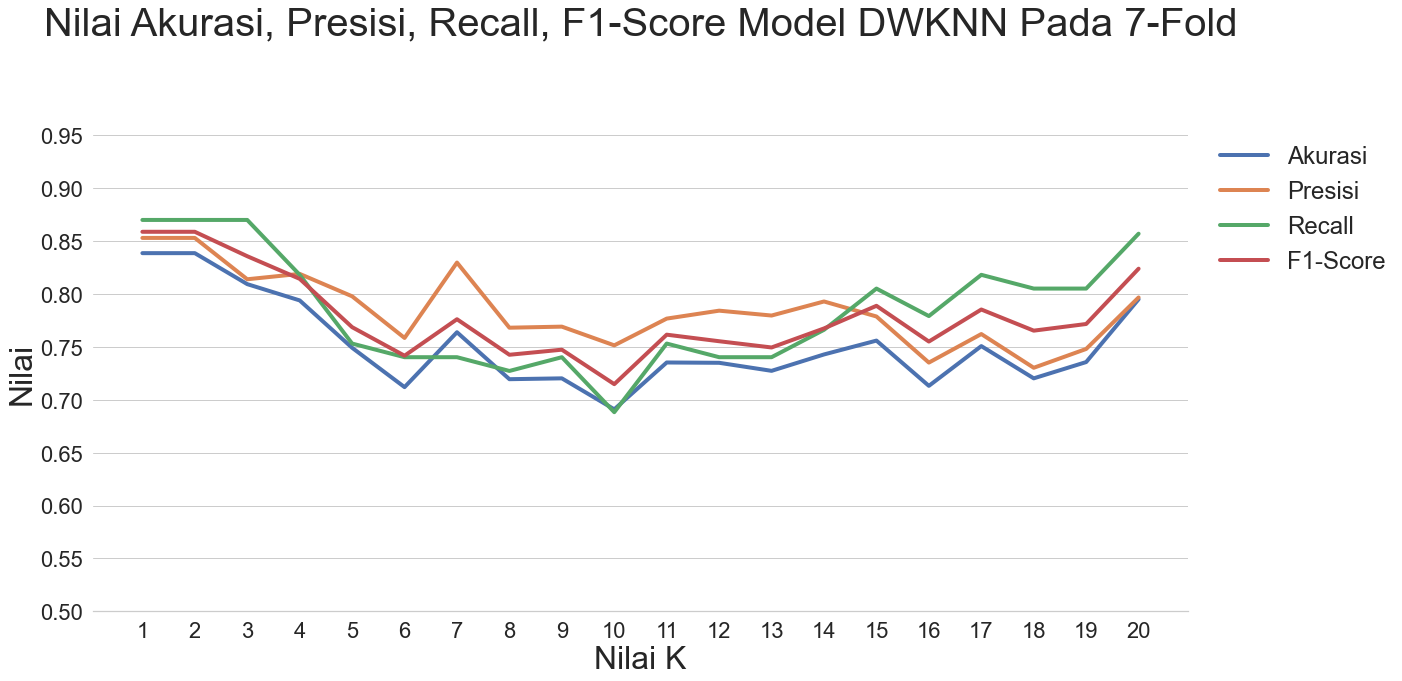

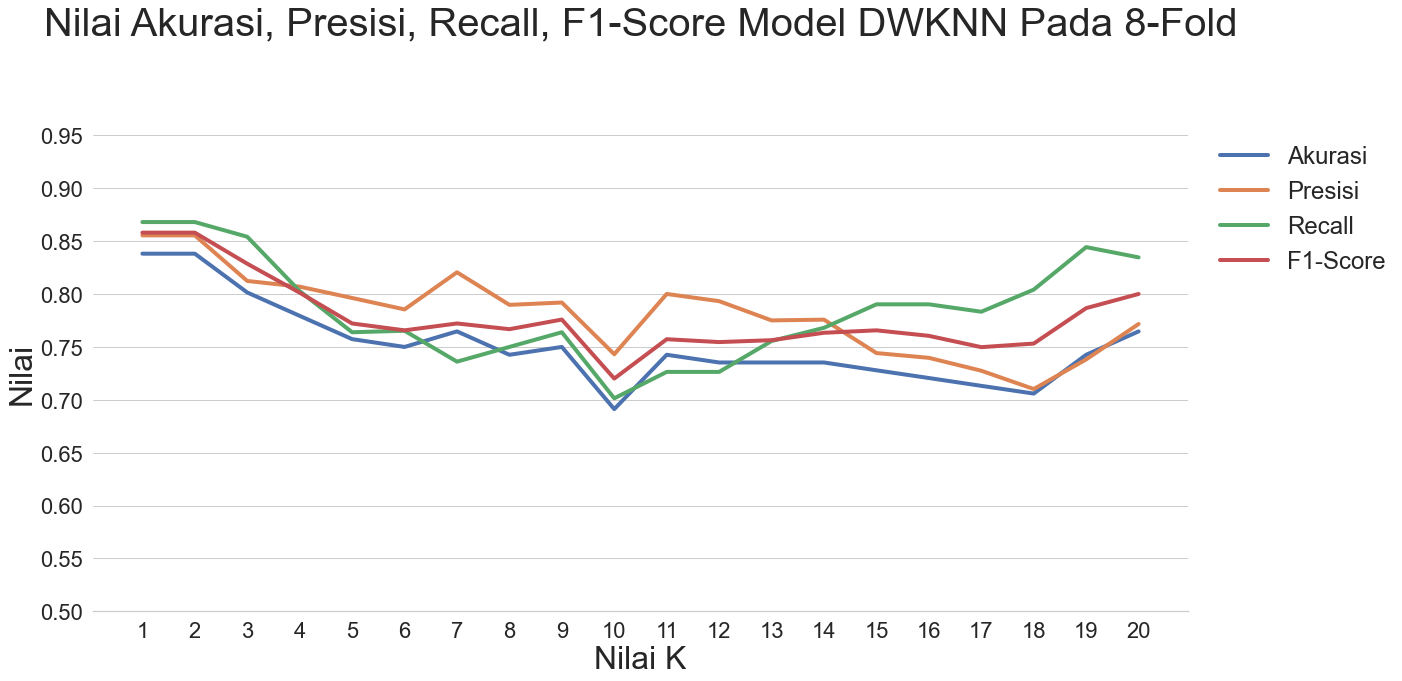

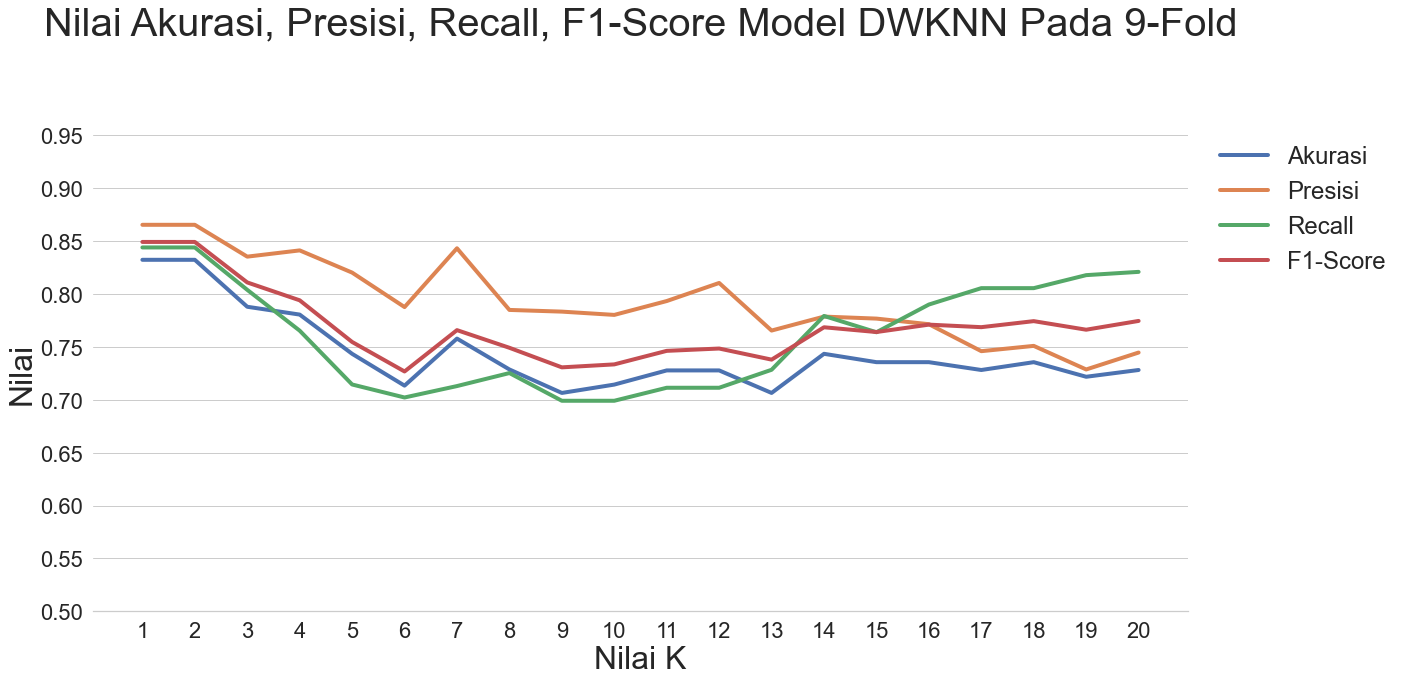

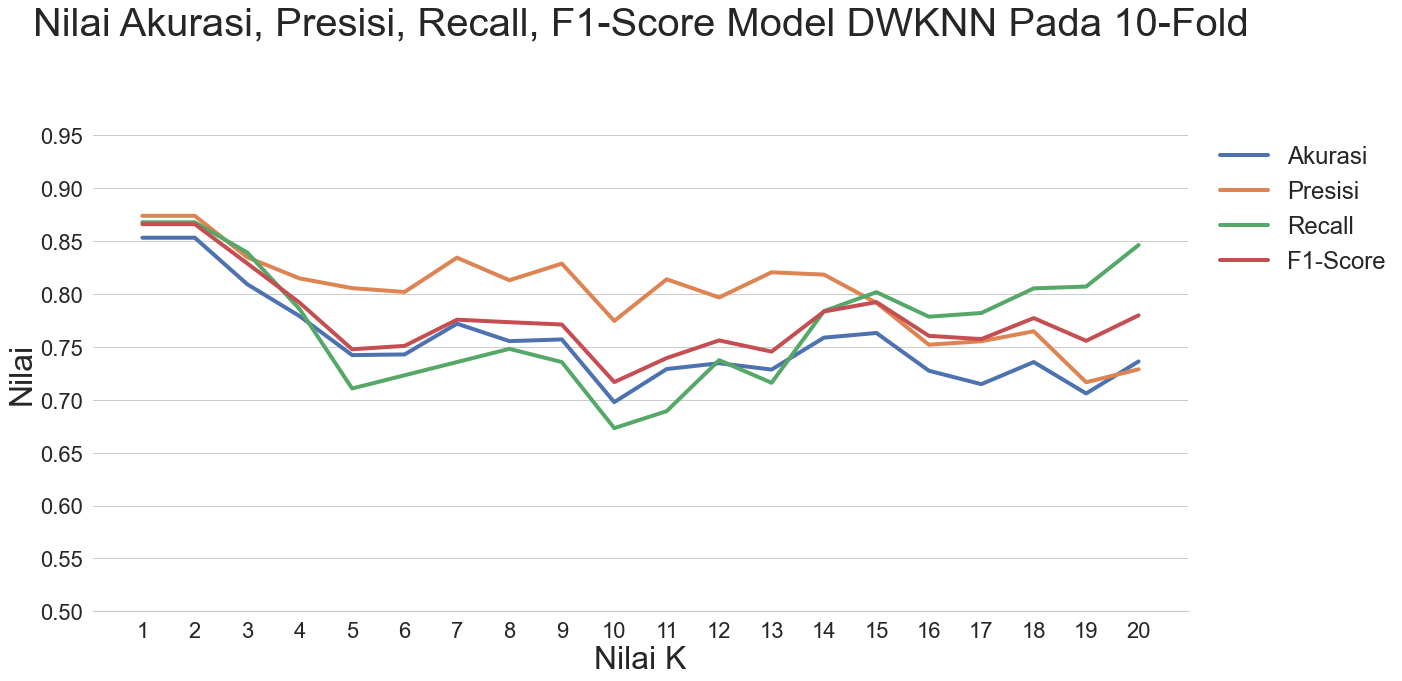

In [234]:
for i in range(9):
    plt.figure(figsize=(20,10))
    plt.rcParams['figure.autolayout'] = True
    sns.set(font_scale=2)
    sns.set_style('whitegrid')
    p = sns.lineplot(range_k0, kfld_d_acc[i], label='Akurasi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_prc[i], label='Presisi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_rcl[i], label='Recall', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_f1[i], label='F1-Score', linewidth=4)
    p.set_title('Nilai Akurasi, Presisi, Recall, F1-Score Model DWKNN Pada {}-Fold'.format(i+2), fontsize=40, y=1.2)
    p.xaxis.grid(False)
    p.set_xlabel('Nilai K', fontsize=32)
    p.set_xticks(range(1,21))
    p.set_ylabel('Nilai', fontsize=32)
    p.set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    sns.despine(left=True, bottom=False)
    p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
    p_fig = p.get_figure()
    p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Prostate/DW Per Fold/DW {}-Fold.png'.format(i+2))